In [103]:
!uv add seaborn plt numpy pandas matplotlib

Current directory does not exist


In [105]:
import re
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "AppleGothic"  # macOS 한글 폰트
plt.rcParams["axes.unicode_minus"] = False
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 100)

# 프로젝트 경로 설정
# 우선순위: 노트북 파일 경로(__vsc_ipynb_file__) > os.getcwd() > 절대 경로 폴백
def _resolve_project_root() -> Path:
    """노트북이 어디서 실행되든 프로젝트 루트를 안정적으로 찾습니다."""
    # 1) Cursor/VS Code 노트북 환경: __vsc_ipynb_file__ 변수 활용
    ipynb_file = globals().get("__vsc_ipynb_file__")
    if ipynb_file:
        return Path(ipynb_file).resolve().parent.parent

    # 2) 일반 Jupyter 환경: os.getcwd() 시도
    try:
        cwd = Path(os.getcwd())
        # notebooks/ 폴더 안에서 실행 중인 경우
        if cwd.name == "notebooks":
            return cwd.parent
        # 프로젝트 루트에서 실행 중인 경우
        if (cwd / "assets" / "data").exists():
            return cwd
        # 그 외: 한 단계 위가 프로젝트 루트
        return cwd.parent
    except OSError:
        pass

    # 3) 폴백: 절대 경로 직접 지정
    return Path("/Users/tylersong/Desktop/workspace/learn/team_prj/report/house-price-prediction")

PROJECT_ROOT = _resolve_project_root()
DATA_DIR = PROJECT_ROOT / "assets" / "data"

# 원격 서버 경로 (해당 시 자동 전환)
REMOTE_DATA_DIR = Path("/data/ephemeral/home/data")
if REMOTE_DATA_DIR.exists():
    DATA_DIR = REMOTE_DATA_DIR

print(f"프로젝트 루트: {PROJECT_ROOT}")
print(f"데이터 디렉토리: {DATA_DIR}")
print(f"데이터 존재 여부: {DATA_DIR.exists()}")

프로젝트 루트: /Users/tylersong/Desktop/workspace/learn/team_prj/report/house-price-prediction
데이터 디렉토리: /Users/tylersong/Desktop/workspace/learn/team_prj/report/house-price-prediction/assets/data
데이터 존재 여부: True


## 1. 데이터 로드 및 기초 탐색

In [ ]:
# ── 데이터 로드 ──
train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df = pd.read_csv(DATA_DIR / "test.csv")

print(f"학습 데이터: {train_df.shape}")
print(f"테스트 데이터: {test_df.shape}")
print(f"\n학습 데이터 컬럼 목록 ({len(train_df.columns)}개):")
print(train_df.columns.tolist())

학습 데이터: (1118822, 52)
테스트 데이터: (9272, 51)

학습 데이터 컬럼 목록 (52개):
['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target']


In [ ]:
# ── 기초 통계 확인 ──
print("=" * 60)
print("학습 데이터 기초 정보")
print("=" * 60)
train_df.info(verbose=True, show_counts=True)

학습 데이터 기초 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  ob

In [ ]:
# ── 수치형 기술통계 ──
train_df.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,해제사유발생일,단지소개기존clob,k-전체동수,k-전체세대수,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target
count,1.118747e+06,1.118747e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,5.983000e+03,68582.000000,248192.000000,249259.000000,2.492590e+05,249214.000000,249259.000000,249214.000000,249214.000000,249214.000000,327.0,2.491080e+05,249108.000000,249152.000000,249152.000000,1.118822e+06
mean,5.649108e+02,5.978885e+00,7.717475e+01,2.014760e+05,1.580656e+01,8.871968e+00,1.998755e+03,2.021057e+07,541.529979,14.798346,1184.124593,1.614967e+05,94210.104998,120726.487549,477.912838,476.713439,167.528470,70.0,1.895070e+05,1063.678778,126.995228,37.545785,5.799153e+04
std,5.160642e+02,4.668584e+01,2.936423e+01,4.187868e+02,8.721166e+00,5.982584e+00,9.333908e+00,1.060697e+04,751.809853,17.693533,1191.474680,1.839856e+05,101905.956897,129020.276480,759.909400,727.553569,248.928143,0.0,1.729027e+06,1235.437604,0.091045,0.052483,4.642602e+04
min,0.000000e+00,0.000000e+00,1.002000e+01,2.007010e+05,1.000000e+00,-4.000000e+00,1.961000e+03,2.020022e+07,1.000000,1.000000,59.000000,0.000000e+00,2338.000000,0.000000,0.000000,0.000000,0.000000,70.0,0.000000e+00,0.000000,126.798318,37.447843,3.500000e+02
25%,1.760000e+02,0.000000e+00,5.965000e+01,2.011100e+05,8.000000e+00,4.000000e+00,1.992000e+03,2.020082e+07,4.000000,5.000000,403.000000,5.366600e+04,31934.000000,40735.000000,48.000000,95.000000,0.000000,70.0,0.000000e+00,315.000000,126.913157,37.499201,3.050000e+04
50%,4.700000e+02,0.000000e+00,8.188000e+01,2.015070e+05,1.600000e+01,8.000000e+00,2.000000e+03,2.021030e+07,174.000000,10.000000,768.000000,1.016330e+05,60280.000000,78125.000000,225.000000,256.000000,63.000000,70.0,1.710550e+03,683.000000,127.014971,37.544936,4.480000e+04
75%,7.810000e+02,1.000000e+00,8.496000e+01,2.018040e+05,2.300000e+01,1.200000e+01,2.005000e+03,2.022021e+07,725.000000,17.000000,1622.000000,2.039040e+05,117086.000000,159544.000000,576.000000,582.000000,237.000000,70.0,8.414210e+03,1274.000000,127.059590,37.577117,6.980000e+04
max,4.974000e+03,2.837000e+03,4.243200e+02,2.023060e+05,3.100000e+01,6.900000e+01,2.023000e+03,2.023093e+07,2888.000000,124.000000,9510.000000,9.591851e+06,734781.000000,969877.000000,4975.000000,5132.000000,1500.000000,70.0,3.159620e+07,12096.000000,127.179998,37.687725,1.450000e+06


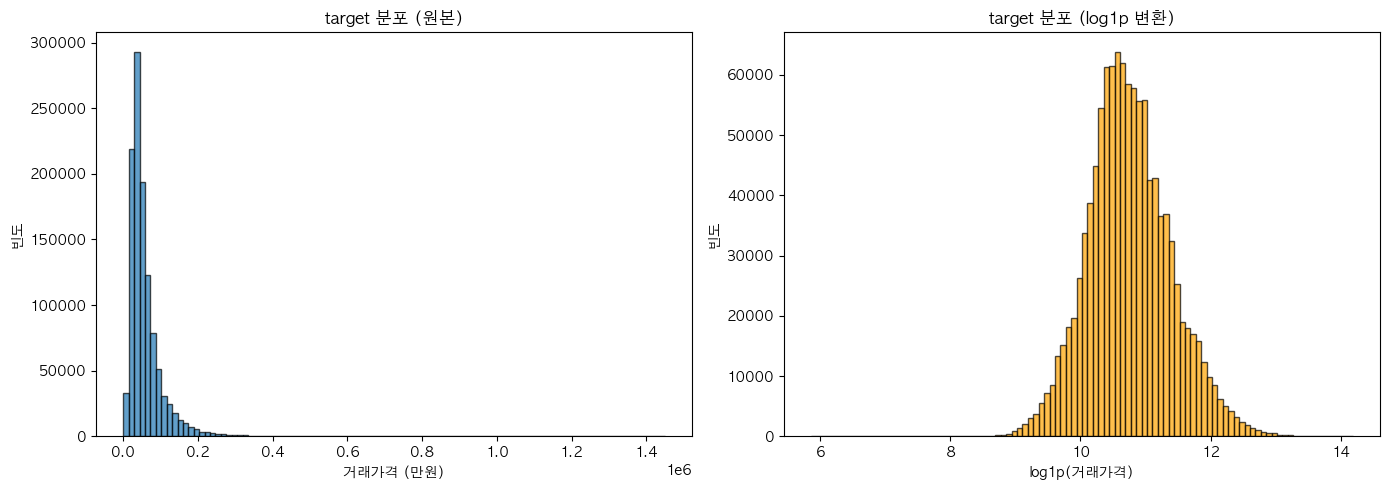

target 왜도(skewness): 3.5176
log1p(target) 왜도: 0.2813


In [ ]:
# ── target 분포 확인 ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df["target"], bins=100, edgecolor="black", alpha=0.7)
axes[0].set_title("target 분포 (원본)")
axes[0].set_xlabel("거래가격 (만원)")
axes[0].set_ylabel("빈도")

axes[1].hist(np.log1p(train_df["target"]), bins=100, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_title("target 분포 (log1p 변환)")
axes[1].set_xlabel("log1p(거래가격)")
axes[1].set_ylabel("빈도")

plt.tight_layout()
plt.show()

print(f"target 왜도(skewness): {train_df['target'].skew():.4f}")
print(f"log1p(target) 왜도: {np.log1p(train_df['target']).skew():.4f}")

In [ ]:
# ── 결측 비율 확인 ──
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
missing_info = pd.DataFrame({
    "결측 수": missing,
    "결측 비율(%)": missing_pct,
}).sort_values("결측 비율(%)", ascending=False)

print("결측 비율이 높은 컬럼 (상위 20개):")
print(missing_info[missing_info["결측 비율(%)"] > 0].head(20))

결측 비율이 높은 컬럼 (상위 20개):
                       결측 수  결측 비율(%)
k-135㎡초과            1118495     99.97
해제사유발생일             1112839     99.47
k-등록일자              1107832     99.02
단지소개기존clob          1050240     93.87
k-홈페이지              1005647     89.88
고용보험관리번호             913304     81.63
세대전기계약방법             878747     78.54
k-팩스번호               872742     78.01
청소비관리형태              871178     77.87
k-시행사                871254     77.87
k-건설사(시공사)           871058     77.85
경비비관리형태              870988     77.85
k-단지분류(아파트,주상복합등등)   870691     77.82
k-전체동수               870630     77.82
단지승인일                870286     77.79
k-전화번호               870274     77.78
k-복도유형               869890     77.75
건축면적                 869714     77.73
좌표X                  869670     77.73
k-수정일자               869608     77.73


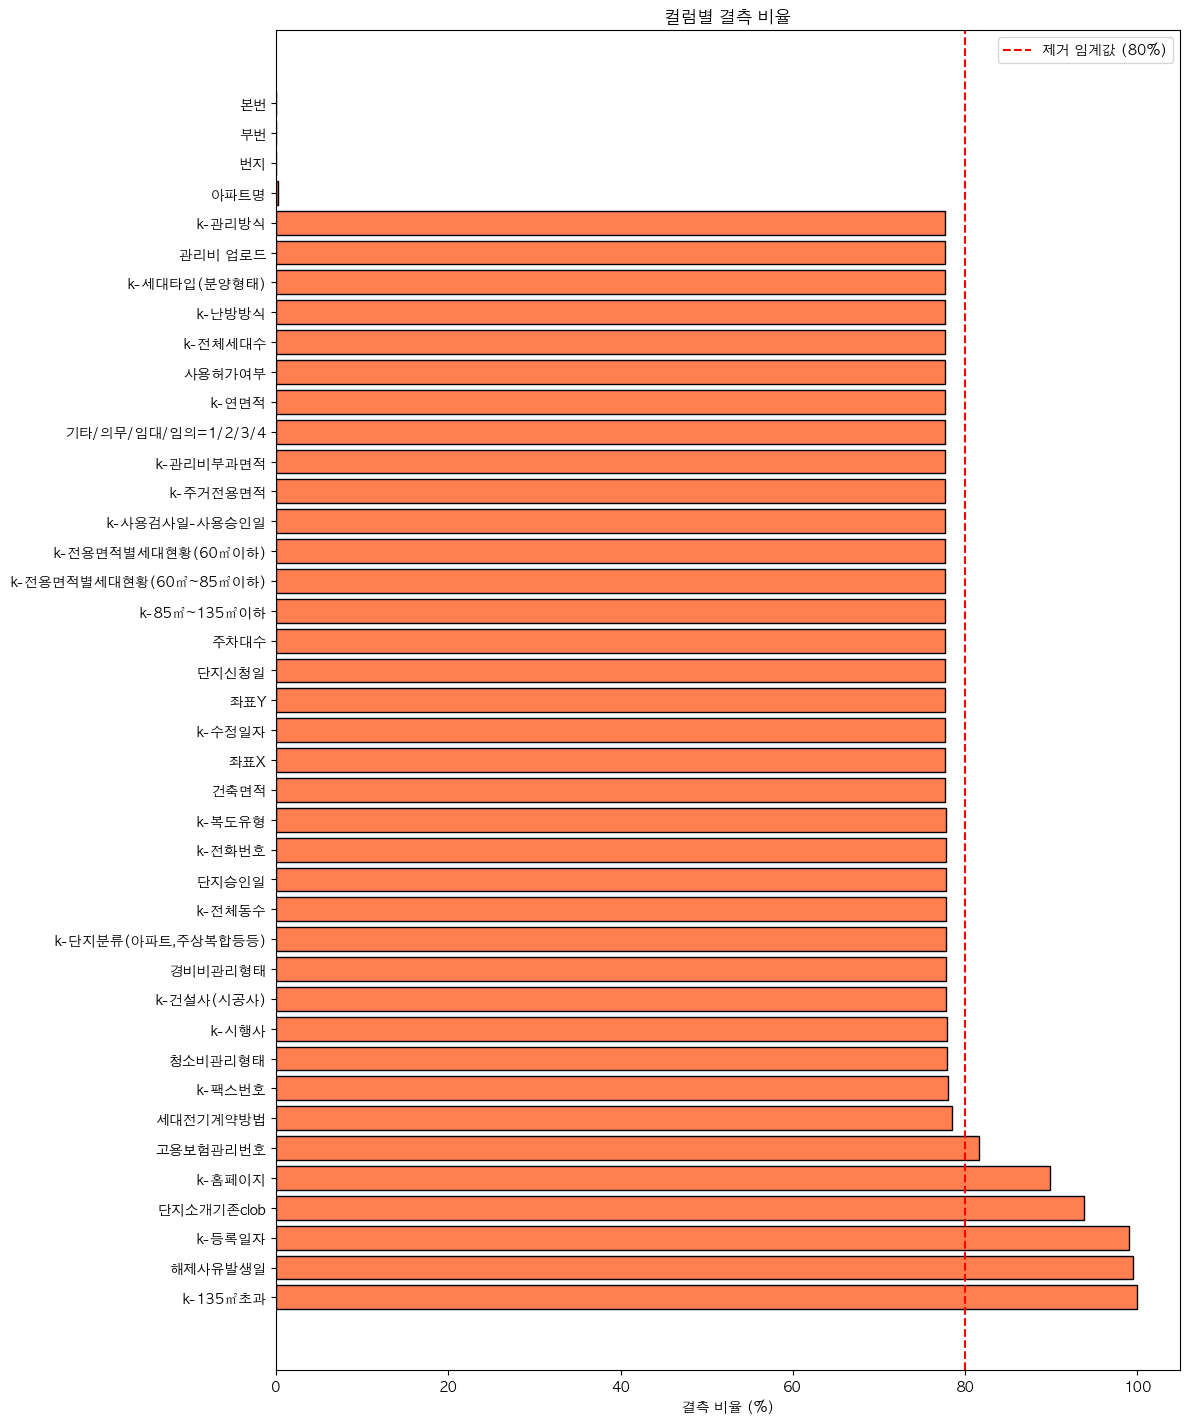

In [ ]:
# ── 결측 비율 시각화 (결측이 있는 컬럼만) ──
missing_cols = missing_info[missing_info["결측 비율(%)"] > 0]

if len(missing_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, max(6, len(missing_cols) * 0.35)))
    ax.barh(missing_cols.index, missing_cols["결측 비율(%)"], color="coral", edgecolor="black")
    ax.set_xlabel("결측 비율 (%)")
    ax.set_title("컬럼별 결측 비율")
    ax.axvline(x=80, color="red", linestyle="--", label="제거 임계값 (80%)")
    ax.legend()
    plt.tight_layout()
    plt.show()

---

## EDA (탐색적 데이터 분석)

전처리 전략을 수립하기 위해 원본 데이터의 분포, 상관관계, 시계열 트렌드, 지리적 패턴을 분석합니다.

### EDA 목차
1. Target 심층 분석 (분포, 가격대별, 세대타입별)
2. 주요 수치형 피처 분포 및 Target 상관관계
3. 범주형 피처별 Target 분포
4. 시계열 트렌드 (연도/월별 거래 건수 및 가격 추이)
5. 좌표 기반 지리적 분포
6. Train / Test 분포 비교
7. 수치형 피처 간 상관관계 히트맵

### EDA-1. Target 심층 분석

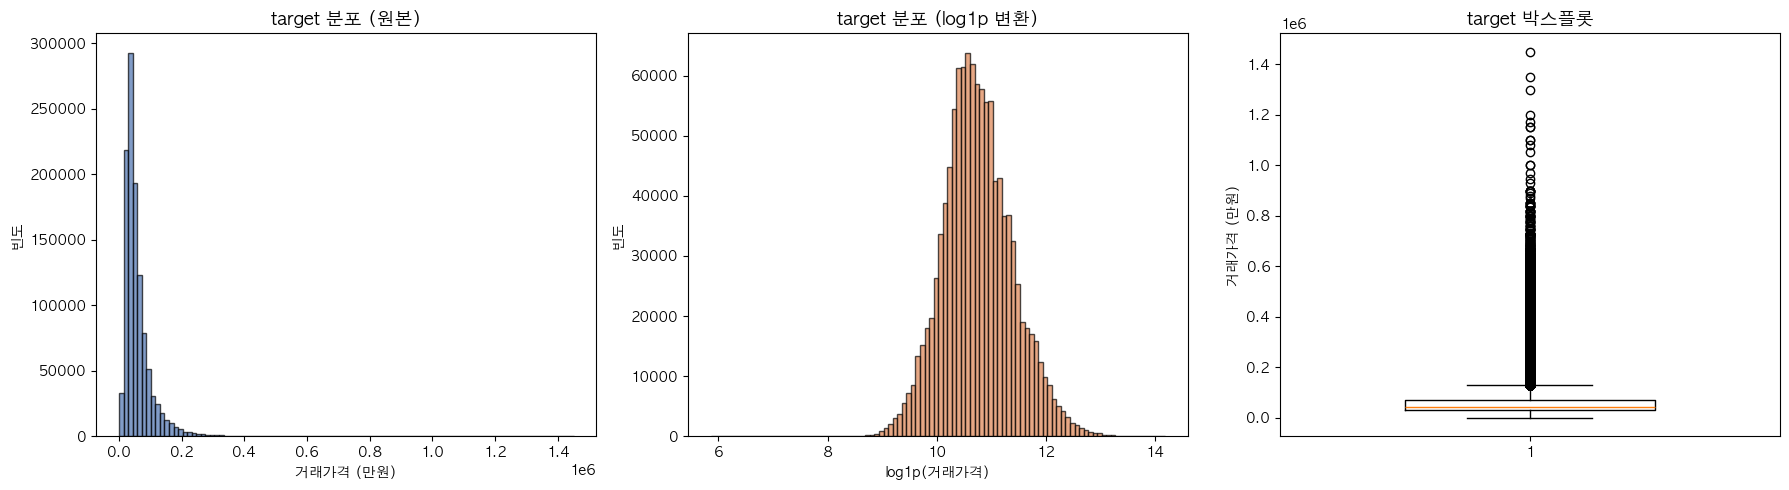

target 기본 통계:
  평균:            57,992 만원
  중앙값:          44,800 만원
  표준편차:         46,426 만원
  최소:               350 만원
  최대:         1,450,000 만원
  왜도(skewness):  3.5176
  첨도(kurtosis):  25.4654
  log1p 왜도:      0.2813


In [ ]:
# ── EDA-1a: Target 기본 분포 (원본 vs log1p) ──
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 원본 분포
axes[0].hist(train_df["target"], bins=100, edgecolor="black", alpha=0.7, color="#4C72B0")
axes[0].set_title("target 분포 (원본)", fontsize=13)
axes[0].set_xlabel("거래가격 (만원)")
axes[0].set_ylabel("빈도")

# log1p 분포
axes[1].hist(np.log1p(train_df["target"]), bins=100, edgecolor="black", alpha=0.7, color="#DD8452")
axes[1].set_title("target 분포 (log1p 변환)", fontsize=13)
axes[1].set_xlabel("log1p(거래가격)")
axes[1].set_ylabel("빈도")

# 박스플롯
axes[2].boxplot(train_df["target"], vert=True, widths=0.5)
axes[2].set_title("target 박스플롯", fontsize=13)
axes[2].set_ylabel("거래가격 (만원)")

plt.tight_layout()
plt.show()

print(f"target 기본 통계:")
print(f"  평균:   {train_df['target'].mean():>15,.0f} 만원")
print(f"  중앙값: {train_df['target'].median():>15,.0f} 만원")
print(f"  표준편차:{train_df['target'].std():>15,.0f} 만원")
print(f"  최소:   {train_df['target'].min():>15,.0f} 만원")
print(f"  최대:   {train_df['target'].max():>15,.0f} 만원")
print(f"  왜도(skewness):  {train_df['target'].skew():.4f}")
print(f"  첨도(kurtosis):  {train_df['target'].kurt():.4f}")
print(f"  log1p 왜도:      {np.log1p(train_df['target']).skew():.4f}")

In [ ]:
# ── EDA-1b: k-세대타입(분양형태)별 Target 분포 ──
# 분양/임대/기타에 따라 target 의미가 다름 (매매가 vs 전세보증금)
type_col = "k-세대타입(분양형태)"
if type_col in train_df.columns:
    temp = train_df[[type_col, "target"]].copy()
    temp[type_col] = temp[type_col].fillna("결측")

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # 건수 비교
    counts = temp[type_col].value_counts()
    axes[0].barh(counts.index, counts.values, color=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])
    axes[0].set_title("세대타입별 거래 건수", fontsize=13)
    axes[0].set_xlabel("건수")
    for i, (idx, v) in enumerate(counts.items()):
        axes[0].text(v + counts.max() * 0.01, i, f"{v:,}", va="center", fontsize=10)

    # 가격 분포 (박스플롯)
    type_order = temp[type_col].value_counts().index.tolist()
    data_list = [temp[temp[type_col] == t]["target"].values for t in type_order]
    bp = axes[1].boxplot(data_list, labels=type_order, vert=True, widths=0.5, showfliers=False)
    axes[1].set_title("세대타입별 target 분포 (이상치 제외)", fontsize=13)
    axes[1].set_ylabel("거래가격 (만원)")

    plt.tight_layout()
    plt.show()

    # 통계표
    print("세대타입별 target 통계:")
    print(temp.groupby(type_col)["target"].agg(["count", "mean", "median", "std"]).round(0).to_string())
else:
    print(f"'{type_col}' 컬럼이 데이터에 없습니다.")

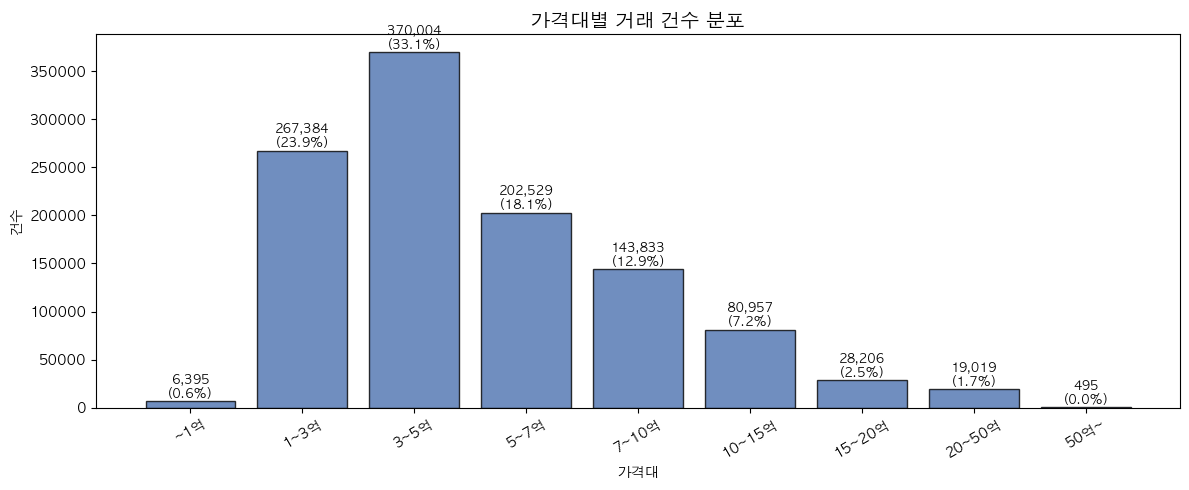

In [ ]:
# ── EDA-1c: 가격대별 분포 ──
price_bins = [0, 10000, 30000, 50000, 70000, 100000, 150000, 200000, 500000, float("inf")]
price_labels = [
    "~1억", "1~3억", "3~5억", "5~7억", "7~10억",
    "10~15억", "15~20억", "20~50억", "50억~"
]
train_df["price_range"] = pd.cut(train_df["target"], bins=price_bins, labels=price_labels)

fig, ax = plt.subplots(figsize=(12, 5))
counts = train_df["price_range"].value_counts().reindex(price_labels)
bars = ax.bar(counts.index, counts.values, color="#4C72B0", edgecolor="black", alpha=0.8)
ax.set_title("가격대별 거래 건수 분포", fontsize=14)
ax.set_xlabel("가격대")
ax.set_ylabel("건수")
plt.xticks(rotation=30)

for bar, v in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, v + counts.max() * 0.01,
            f"{v:,}\n({v/len(train_df)*100:.1f}%)", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# 정리
train_df.drop(columns=["price_range"], inplace=True)

### EDA-2. 주요 수치형 피처 분포 및 Target 상관관계

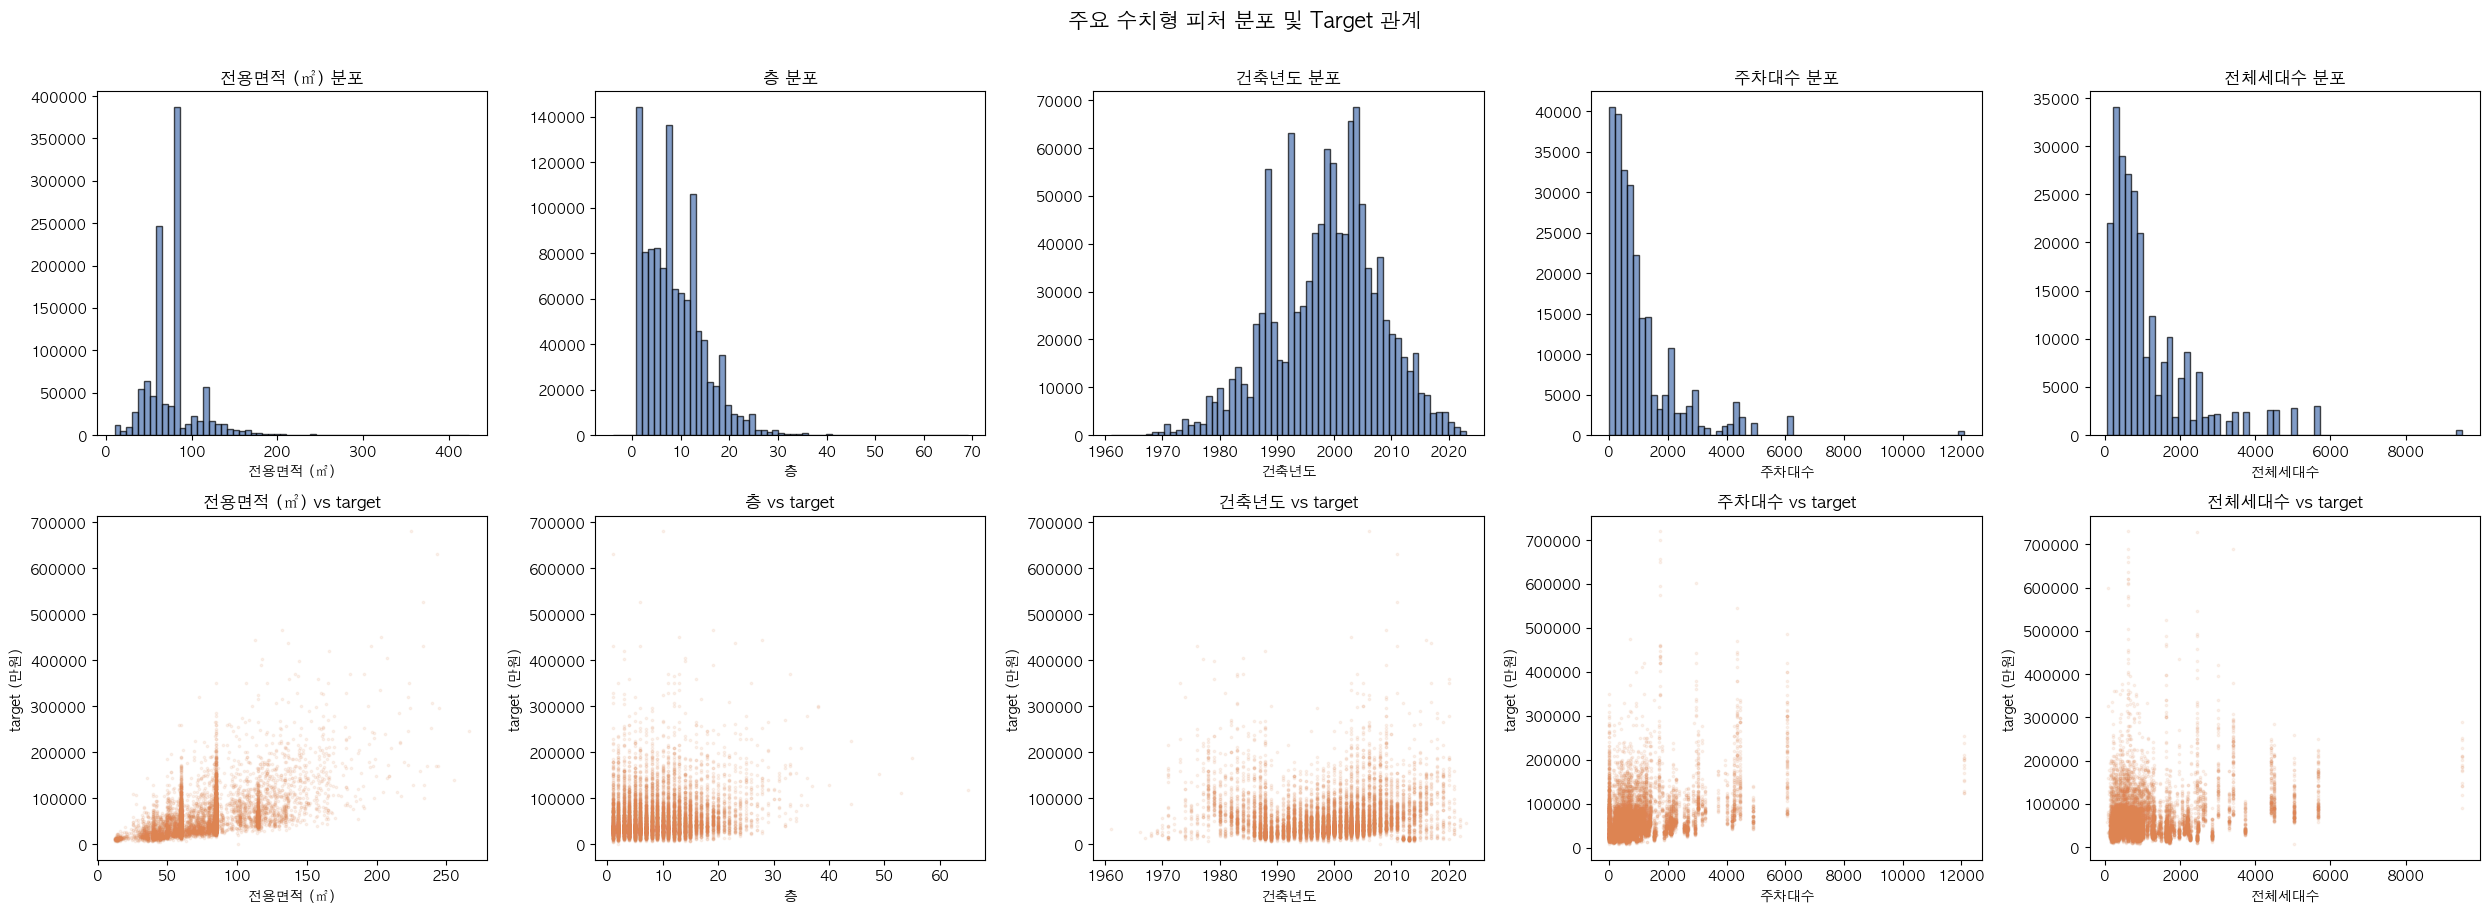

In [ ]:
# ── EDA-2a: 주요 수치형 피처 분포 ──
num_features = {
    "전용면적(㎡)": "전용면적 (㎡)",
    "층": "층",
    "건축년도": "건축년도",
    "주차대수": "주차대수",
    "k-전체세대수": "전체세대수",
}
available = {k: v for k, v in num_features.items() if k in train_df.columns}

fig, axes = plt.subplots(2, len(available), figsize=(5 * len(available), 9))

for i, (col, label) in enumerate(available.items()):
    # 상단: 히스토그램
    axes[0, i].hist(train_df[col].dropna(), bins=60, edgecolor="black", alpha=0.7, color="#4C72B0")
    axes[0, i].set_title(f"{label} 분포", fontsize=12)
    axes[0, i].set_xlabel(label)

    # 하단: target과의 scatter (샘플링)
    sample = train_df[[col, "target"]].dropna().sample(min(10000, len(train_df)), random_state=42)
    axes[1, i].scatter(sample[col], sample["target"], alpha=0.1, s=3, color="#DD8452")
    axes[1, i].set_title(f"{label} vs target", fontsize=12)
    axes[1, i].set_xlabel(label)
    axes[1, i].set_ylabel("target (만원)")

plt.suptitle("주요 수치형 피처 분포 및 Target 관계", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

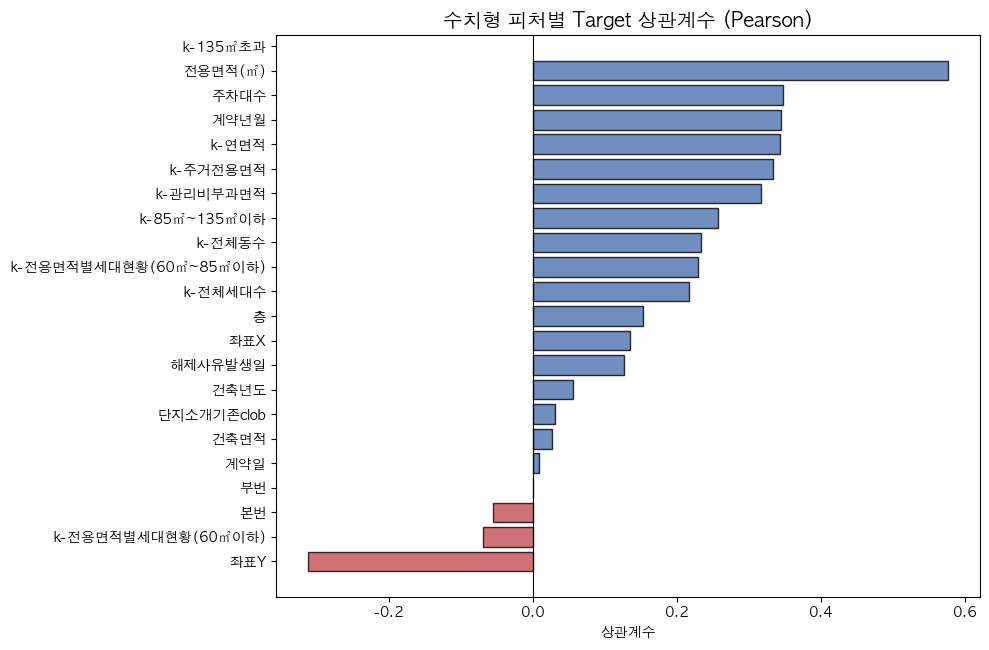

상관계수 상위 10개:
전용면적(㎡)                   0.577041
주차대수                      0.348141
계약년월                      0.344665
k-연면적                     0.343594
k-주거전용면적                  0.334076
k-관리비부과면적                 0.316773
좌표Y                       0.312180
k-85㎡~135㎡이하              0.257145
k-전체동수                    0.234470
k-전용면적별세대현황(60㎡~85㎡이하)    0.229618


In [ ]:
# ── EDA-2b: 수치형 피처별 Target 상관계수 ──
num_cols_for_corr = [c for c in train_df.select_dtypes(include=[np.number]).columns if c != "target"]
corr_with_target = train_df[num_cols_for_corr + ["target"]].corr()["target"].drop("target").sort_values()

fig, ax = plt.subplots(figsize=(10, max(6, len(corr_with_target) * 0.3)))
colors = ["#C44E52" if v < 0 else "#4C72B0" for v in corr_with_target.values]
ax.barh(corr_with_target.index, corr_with_target.values, color=colors, edgecolor="black", alpha=0.8)
ax.set_title("수치형 피처별 Target 상관계수 (Pearson)", fontsize=14)
ax.set_xlabel("상관계수")
ax.axvline(x=0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

print("상관계수 상위 10개:")
print(corr_with_target.abs().sort_values(ascending=False).head(10).to_string())

### EDA-3. 범주형 피처별 Target 분포

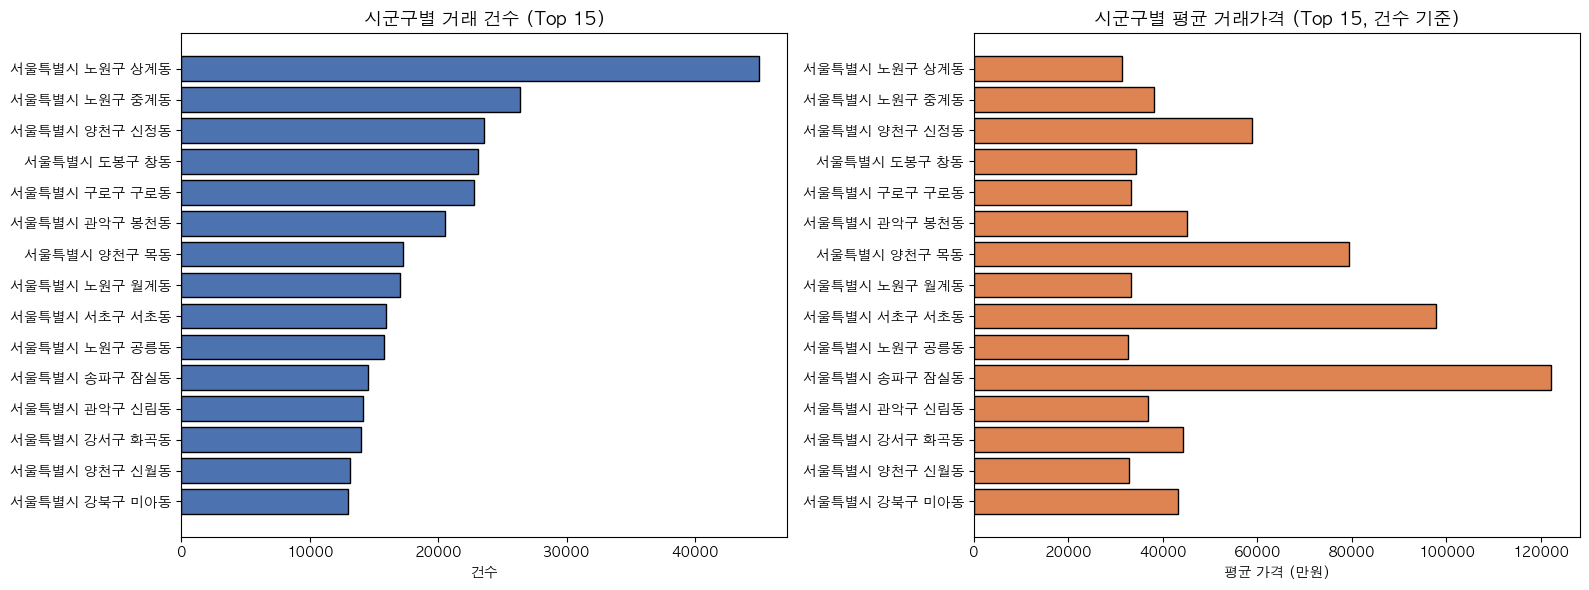

In [ ]:
# ── EDA-3a: 시군구 상위 15개 — 거래 건수 및 평균 가격 ──
sigungu_stats = (
    train_df.groupby("시군구")["target"]
    .agg(["count", "mean", "median"])
    .sort_values("count", ascending=False)
    .head(15)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 거래 건수
axes[0].barh(sigungu_stats.index[::-1], sigungu_stats["count"][::-1], color="#4C72B0", edgecolor="black")
axes[0].set_title("시군구별 거래 건수 (Top 15)", fontsize=13)
axes[0].set_xlabel("건수")

# 평균 가격
axes[1].barh(sigungu_stats.index[::-1], sigungu_stats["mean"][::-1], color="#DD8452", edgecolor="black")
axes[1].set_title("시군구별 평균 거래가격 (Top 15, 건수 기준)", fontsize=13)
axes[1].set_xlabel("평균 가격 (만원)")

plt.tight_layout()
plt.show()

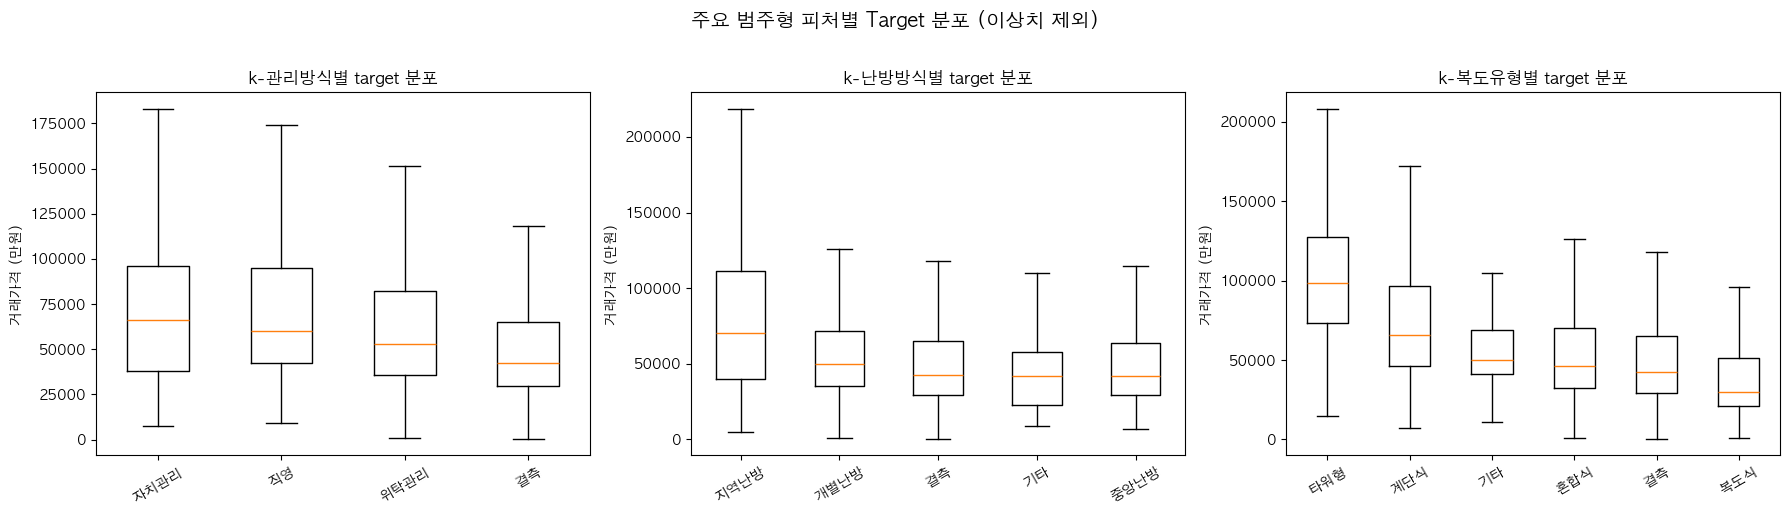

In [ ]:
# ── EDA-3b: k-관리방식, k-난방방식, k-복도유형별 target 분포 ──
cat_features = ["k-관리방식", "k-난방방식", "k-복도유형"]
cat_available = [c for c in cat_features if c in train_df.columns]

if cat_available:
    fig, axes = plt.subplots(1, len(cat_available), figsize=(6 * len(cat_available), 5))
    if len(cat_available) == 1:
        axes = [axes]

    for ax, col in zip(axes, cat_available):
        temp = train_df[[col, "target"]].copy()
        temp[col] = temp[col].fillna("결측")
        order = temp.groupby(col)["target"].median().sort_values(ascending=False).index
        data_list = [temp[temp[col] == cat]["target"].values for cat in order]
        bp = ax.boxplot(data_list, labels=order, vert=True, widths=0.5, showfliers=False)
        ax.set_title(f"{col}별 target 분포", fontsize=12)
        ax.set_ylabel("거래가격 (만원)")
        ax.tick_params(axis="x", rotation=30)

    plt.suptitle("주요 범주형 피처별 Target 분포 (이상치 제외)", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

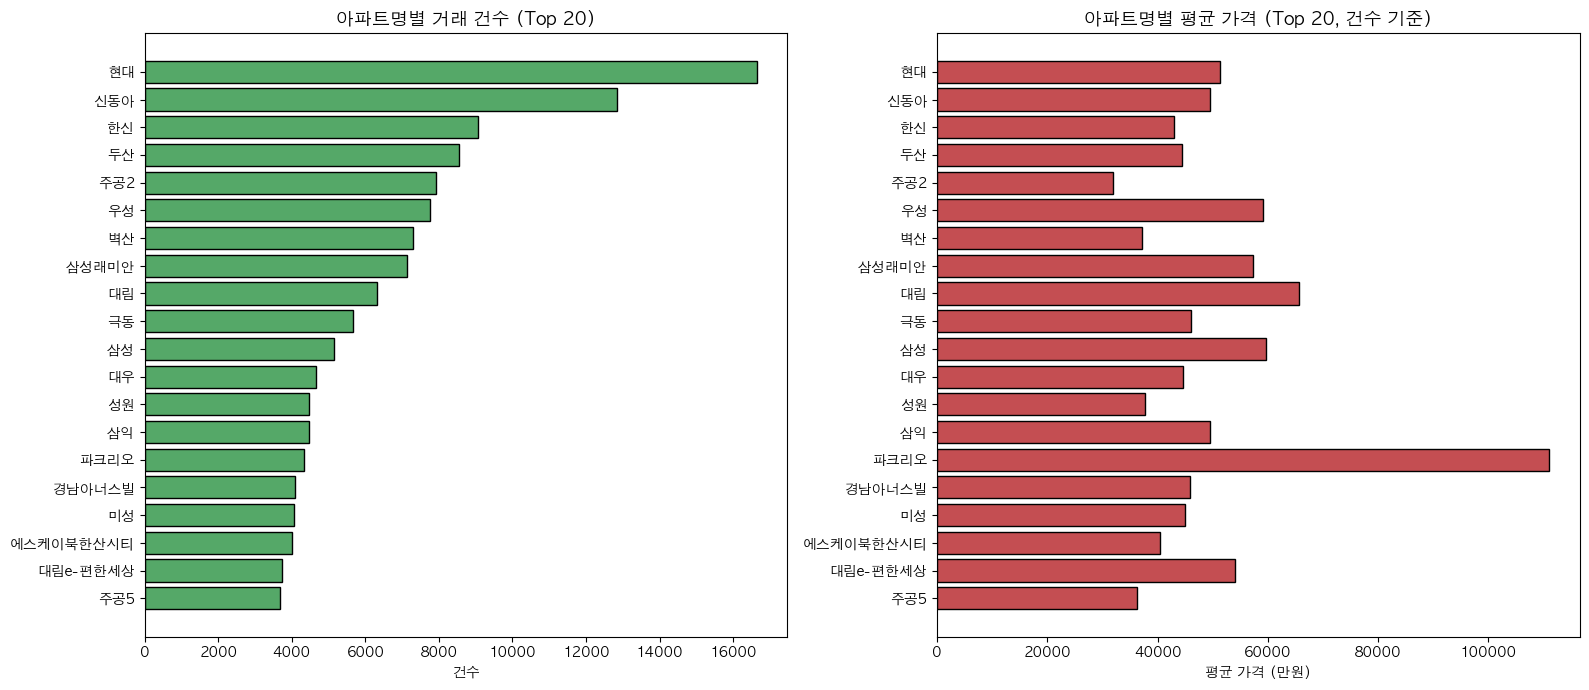

아파트명 고유값 수: 6,538개


In [ ]:
# ── EDA-3c: 아파트명 상위 20개 — 거래 건수 및 평균 가격 ──
apt_stats = (
    train_df.groupby("아파트명")["target"]
    .agg(["count", "mean"])
    .sort_values("count", ascending=False)
    .head(20)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].barh(apt_stats.index[::-1], apt_stats["count"][::-1], color="#55A868", edgecolor="black")
axes[0].set_title("아파트명별 거래 건수 (Top 20)", fontsize=13)
axes[0].set_xlabel("건수")

axes[1].barh(apt_stats.index[::-1], apt_stats["mean"][::-1], color="#C44E52", edgecolor="black")
axes[1].set_title("아파트명별 평균 가격 (Top 20, 건수 기준)", fontsize=13)
axes[1].set_xlabel("평균 가격 (만원)")

plt.tight_layout()
plt.show()

print(f"아파트명 고유값 수: {train_df['아파트명'].nunique():,}개")

### EDA-4. 시계열 트렌드 (연도/월별 거래 건수 및 가격 추이)

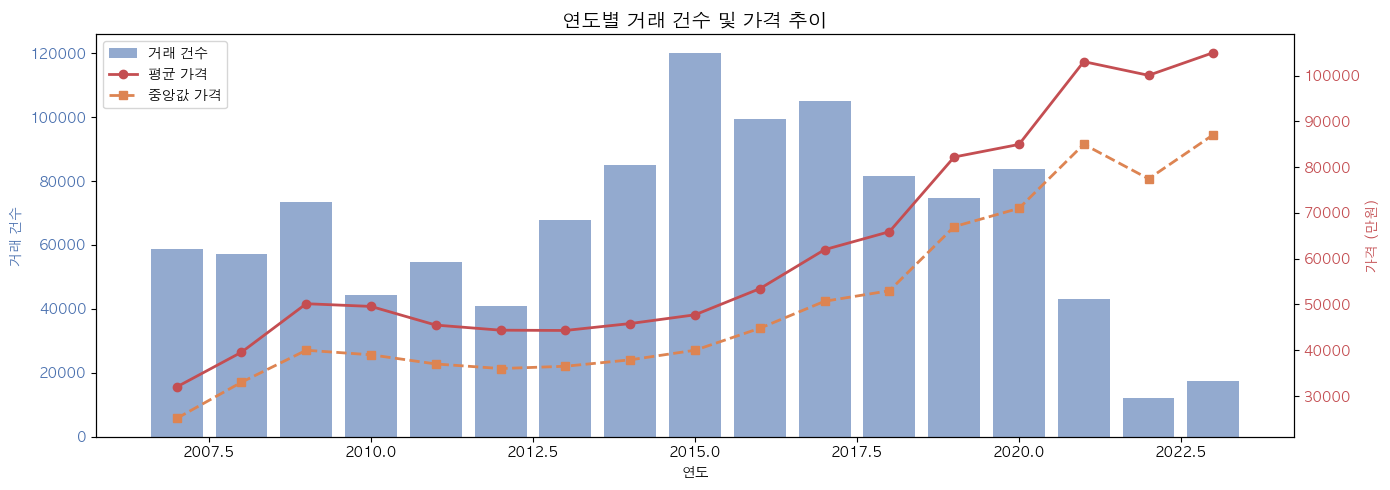

In [ ]:
# ── EDA-4a: 연도별 거래 건수 및 평균 가격 추이 ──
ym = train_df["계약년월"].astype(str)
train_df["_year"] = ym.str[:4].astype(int)
train_df["_month"] = ym.str[4:6].astype(int)

yearly = train_df.groupby("_year")["target"].agg(["count", "mean", "median"])

fig, ax1 = plt.subplots(figsize=(14, 5))

# 거래 건수 (막대)
ax1.bar(yearly.index, yearly["count"], color="#4C72B0", alpha=0.6, label="거래 건수")
ax1.set_xlabel("연도")
ax1.set_ylabel("거래 건수", color="#4C72B0")
ax1.tick_params(axis="y", labelcolor="#4C72B0")

# 평균 가격 (꺾은선)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["mean"], color="#C44E52", marker="o", linewidth=2, label="평균 가격")
ax2.plot(yearly.index, yearly["median"], color="#DD8452", marker="s", linewidth=2, linestyle="--", label="중앙값 가격")
ax2.set_ylabel("가격 (만원)", color="#C44E52")
ax2.tick_params(axis="y", labelcolor="#C44E52")

ax1.set_title("연도별 거래 건수 및 가격 추이", fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

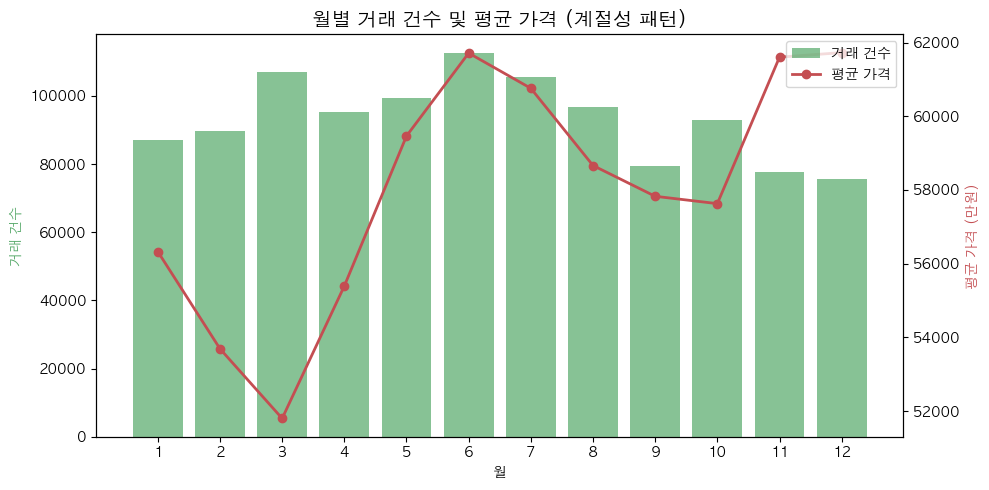

In [ ]:
# ── EDA-4b: 월별 거래 건수 및 계절성 패턴 ──
monthly = train_df.groupby("_month")["target"].agg(["count", "mean"])

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(monthly.index, monthly["count"], color="#55A868", alpha=0.7, label="거래 건수")
ax1.set_xlabel("월")
ax1.set_ylabel("거래 건수", color="#55A868")
ax1.set_xticks(range(1, 13))

ax2 = ax1.twinx()
ax2.plot(monthly.index, monthly["mean"], color="#C44E52", marker="o", linewidth=2, label="평균 가격")
ax2.set_ylabel("평균 가격 (만원)", color="#C44E52")

ax1.set_title("월별 거래 건수 및 평균 가격 (계절성 패턴)", fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

# 정리
train_df.drop(columns=["_year", "_month"], inplace=True)

### EDA-5. 좌표 기반 지리적 분포

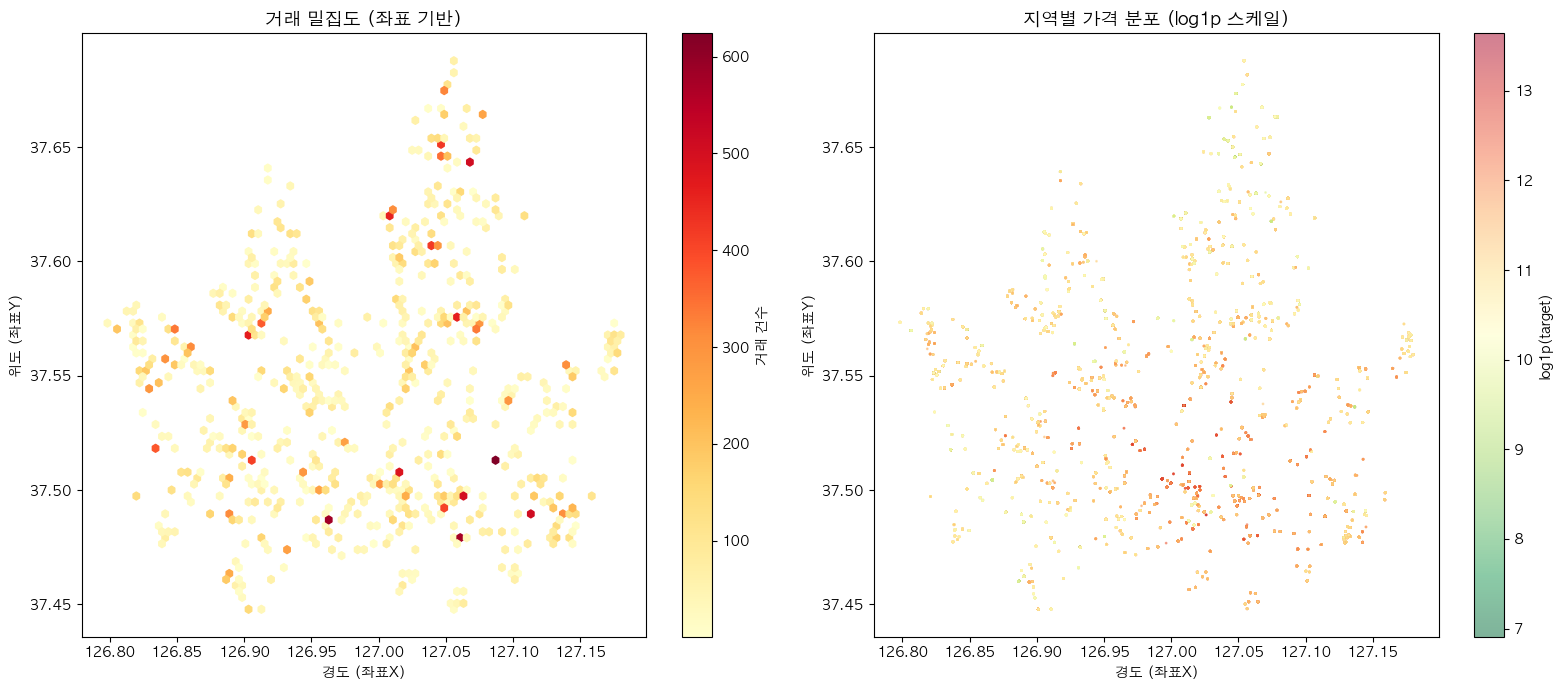

좌표 존재 행: 249,152 / 1,118,822 (22.3%)
좌표 결측 행: 869,670


In [ ]:
# ── EDA-5: 좌표 기반 지리적 분포 (가격 히트맵) ──
coord_valid = train_df[["좌표X", "좌표Y", "target"]].dropna()

if len(coord_valid) > 0:
    # 좌표가 있는 데이터만 샘플링 (시각화 성능)
    sample = coord_valid.sample(min(50000, len(coord_valid)), random_state=42)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # 거래 밀집도
    axes[0].hexbin(
        sample["좌표X"], sample["좌표Y"], gridsize=80,
        cmap="YlOrRd", mincnt=1
    )
    axes[0].set_title("거래 밀집도 (좌표 기반)", fontsize=13)
    axes[0].set_xlabel("경도 (좌표X)")
    axes[0].set_ylabel("위도 (좌표Y)")
    plt.colorbar(axes[0].collections[0], ax=axes[0], label="거래 건수")

    # 가격 분포
    sc = axes[1].scatter(
        sample["좌표X"], sample["좌표Y"],
        c=np.log1p(sample["target"]), cmap="RdYlGn_r",
        s=1, alpha=0.5
    )
    axes[1].set_title("지역별 가격 분포 (log1p 스케일)", fontsize=13)
    axes[1].set_xlabel("경도 (좌표X)")
    axes[1].set_ylabel("위도 (좌표Y)")
    plt.colorbar(sc, ax=axes[1], label="log1p(target)")

    plt.tight_layout()
    plt.show()

    print(f"좌표 존재 행: {len(coord_valid):,} / {len(train_df):,} "
          f"({len(coord_valid)/len(train_df)*100:.1f}%)")
    print(f"좌표 결측 행: {len(train_df) - len(coord_valid):,}")
else:
    print("좌표 데이터가 없습니다.")

### EDA-6. Train / Test 분포 비교

학습 데이터와 테스트 데이터의 분포가 다르면 모델 일반화에 문제가 생길 수 있습니다.

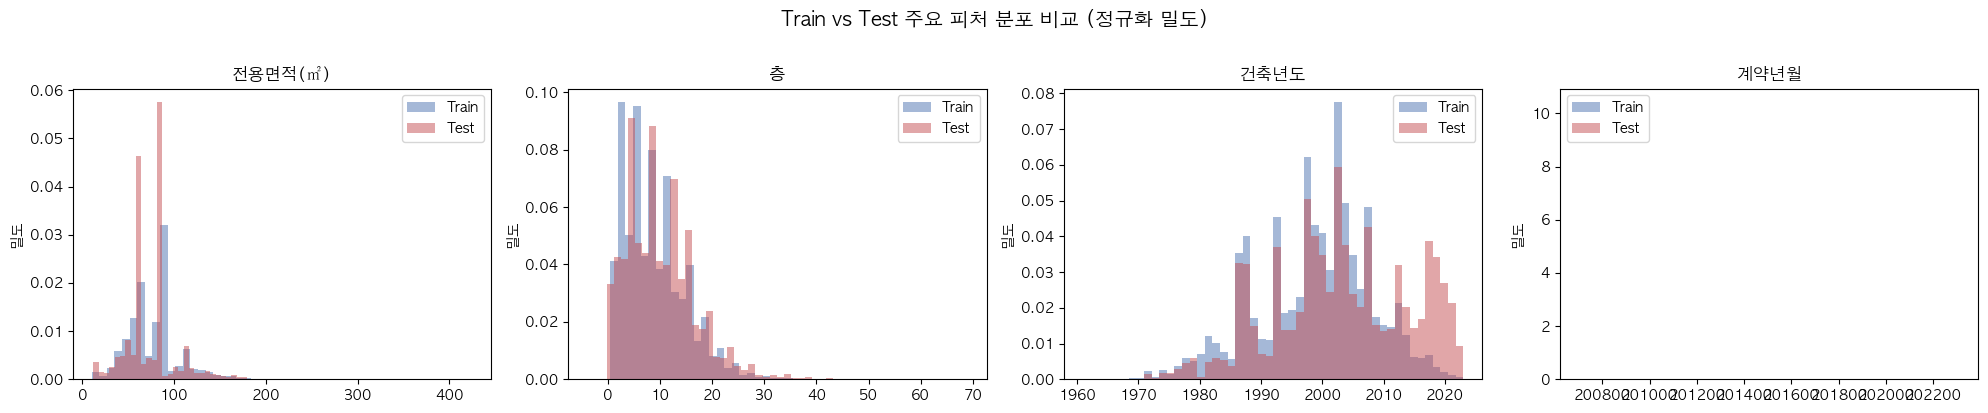

In [ ]:
# ── EDA-6a: 주요 수치형 피처 Train/Test 분포 비교 ──
compare_cols = ["전용면적(㎡)", "층", "건축년도", "계약년월"]
compare_available = [c for c in compare_cols if c in train_df.columns and c in test_df.columns]

fig, axes = plt.subplots(1, len(compare_available), figsize=(5 * len(compare_available), 4))
if len(compare_available) == 1:
    axes = [axes]

for ax, col in zip(axes, compare_available):
    ax.hist(train_df[col].dropna(), bins=50, alpha=0.5, label="Train", density=True, color="#4C72B0")
    ax.hist(test_df[col].dropna(), bins=50, alpha=0.5, label="Test", density=True, color="#C44E52")
    ax.set_title(f"{col}", fontsize=12)
    ax.legend()
    ax.set_ylabel("밀도")

plt.suptitle("Train vs Test 주요 피처 분포 비교 (정규화 밀도)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

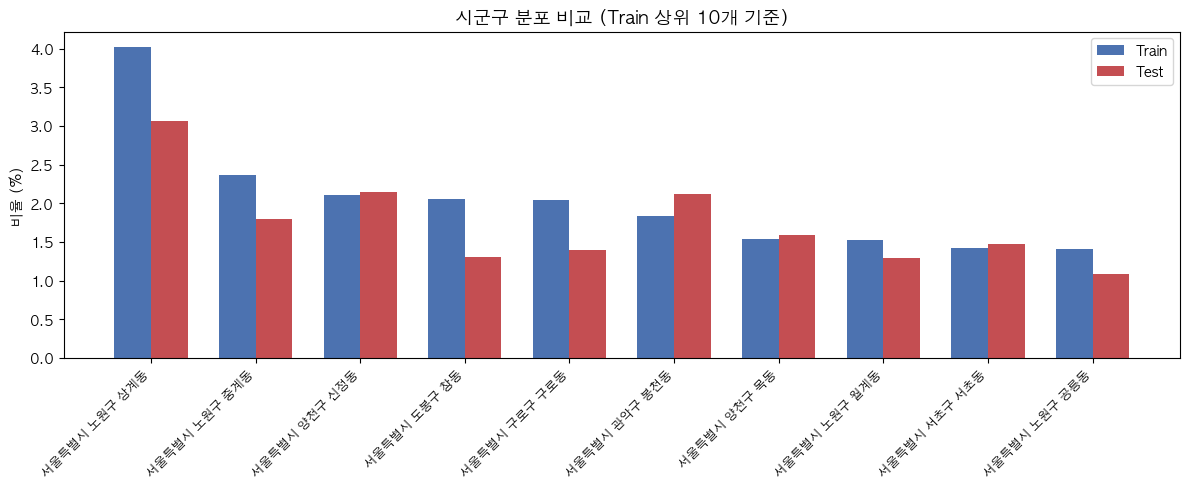

Train 시군구 수: 339
Test 시군구 수:  270
Test의 모든 시군구가 Train에 포함되어 있음


In [ ]:
# ── EDA-6b: 시군구 분포 비교 (상위 10개) ──
train_sigungu = train_df["시군구"].value_counts().head(10)
test_sigungu = test_df["시군구"].value_counts()

# 학습 데이터 상위 10개 시군구 기준으로 비교
compare_sigungu = pd.DataFrame({
    "Train (비율%)": (train_sigungu / len(train_df) * 100).round(2),
    "Test (비율%)": (test_sigungu.reindex(train_sigungu.index).fillna(0) / len(test_df) * 100).round(2),
})

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(compare_sigungu))
width = 0.35
ax.bar(x - width/2, compare_sigungu["Train (비율%)"], width, label="Train", color="#4C72B0")
ax.bar(x + width/2, compare_sigungu["Test (비율%)"], width, label="Test", color="#C44E52")
ax.set_xticks(x)
ax.set_xticklabels(compare_sigungu.index, rotation=45, ha="right", fontsize=9)
ax.set_title("시군구 분포 비교 (Train 상위 10개 기준)", fontsize=13)
ax.set_ylabel("비율 (%)")
ax.legend()
plt.tight_layout()
plt.show()

# 테스트에만 있는 시군구
train_sigungu_set = set(train_df["시군구"].unique())
test_sigungu_set = set(test_df["시군구"].unique())
only_test = test_sigungu_set - train_sigungu_set
print(f"Train 시군구 수: {len(train_sigungu_set):,}")
print(f"Test 시군구 수:  {len(test_sigungu_set):,}")
if only_test:
    print(f"Test에만 있는 시군구 ({len(only_test)}개): {only_test}")
else:
    print("Test의 모든 시군구가 Train에 포함되어 있음")

### EDA-7. 수치형 피처 간 상관관계 히트맵

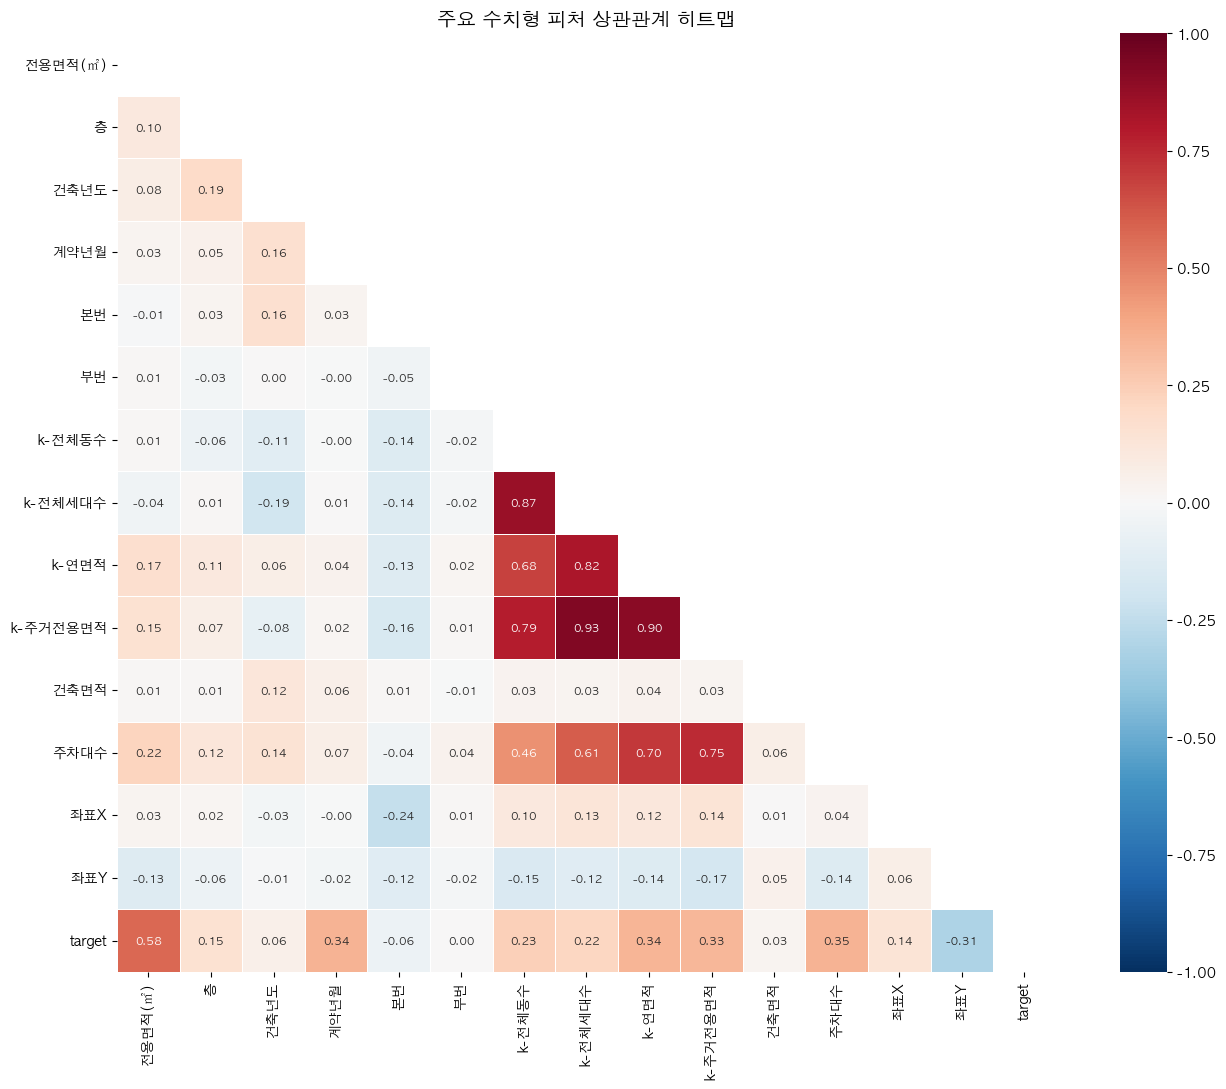

In [ ]:
# ── EDA-7: 수치형 피처 간 상관관계 히트맵 ──
# 주요 수치형 컬럼만 선택 (결측이 적은 컬럼 우선)
key_num_cols = ["전용면적(㎡)", "층", "건축년도", "계약년월", "본번", "부번",
                "k-전체동수", "k-전체세대수", "k-연면적", "k-주거전용면적",
                "건축면적", "주차대수", "좌표X", "좌표Y", "target"]
key_num_available = [c for c in key_num_cols if c in train_df.columns]

corr_matrix = train_df[key_num_available].corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".2f",
    cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    square=True, linewidths=0.5, ax=ax,
    annot_kws={"size": 8}
)
ax.set_title("주요 수치형 피처 상관관계 히트맵", fontsize=14)
plt.tight_layout()
plt.show()

### EDA 요약 — 전처리 전략 수립 근거

| 발견 사항 | 전처리 전략 반영 |
|----------|---------------|
| target이 right-skewed (왜도 높음) | **log1p 변환** 적용하여 정규분포에 가깝게 |
| 가격 범위가 1,000만~200억 (4자릿수) | log 스케일 학습으로 전 가격대 균형 예측 |
| k-세대타입별 target 의미가 다름 (매매 vs 전세) | 제거하지 않고 **범주형 피처로 유지** |
| 결측 80% 이상 컬럼 다수 (해제사유발생일 등) | **80% 임계값**으로 제거, k-* 피처(60~70%)는 보존 |
| 좌표 결측 ~78% (k-* 계열과 연동) | **시군구별 평균**으로 보간 (거리 피처 계산 필수) |
| 아파트명 고유값 20,000+ | One-Hot 불가 → **Target Encoding** 적용 |
| 2020년 이후 급격한 가격 상승 | **시간 기반 샘플 가중치** + TimeSeriesSplit CV |
| 월별 계절성 패턴 존재 (봄 성수기) | **month_sin/cos** 순환 인코딩 |
| 전용면적, 층이 target과 상관관계 높음 | **교호작용 피처** (area × floor) 생성 |
| Train/Test 시군구 분포 유사 | 심각한 분포 이동 없음, 일반화 가능 |

---

---

## 2. 전처리 설정 (Configuration)

전처리에 사용할 상수와 설정값을 정의합니다.

In [ ]:
# ══════════════════════════════════════════════
# 전처리 설정
# ══════════════════════════════════════════════

# 결측 비율 임계값 (이 비율 이상인 컬럼 제거)
MISSING_THRESHOLD = 0.80

# 좌표 보존 컬럼 (고결측이어도 제거하지 않음)
COORD_PRESERVE_COLS = ["좌표X", "좌표Y"]

# 이상치 클리핑 대상 컬럼 및 IQR 배수
OUTLIER_CLIP_COLS = ["전용면적", "층", "건축년도", "주차대수", "k-전체세대수"]
OUTLIER_IQR_FACTOR = 3.0

# Target 이상치 클리핑 (퍼센타일 기반)
TARGET_LOWER_PERCENTILE = 0.001  # 하위 0.1%
TARGET_UPPER_PERCENTILE = 0.999  # 상위 99.9%

# 범주형 식별 기준
CATEGORICAL_UNIQUE_RATIO = 0.10   # 고유값 비율 < 10%
CATEGORICAL_MAX_UNIQUE = 100      # 고유값 수 < 100

# KNN Imputer 설정
KNN_N_NEIGHBORS = 5               # 이웃 수 (distance-weighted)
KNN_SAMPLE_SIZE = 50_000          # KNN 학습용 샘플 크기 (메모리/속도 최적화)
KNN_CHUNK_SIZE = 10_000           # 변환 시 배치 크기

print("전처리 설정 완료")
print(f"  결측 임계값: {MISSING_THRESHOLD*100}%")
print(f"  IQR 이상치 배수: {OUTLIER_IQR_FACTOR}")
print(f"  Target 클리핑: {TARGET_LOWER_PERCENTILE*100}% ~ {TARGET_UPPER_PERCENTILE*100}%")
print(f"  KNN Imputer: k={KNN_N_NEIGHBORS}, 학습 샘플={KNN_SAMPLE_SIZE:,}, 배치={KNN_CHUNK_SIZE:,}")

전처리 설정 완료
  결측 임계값: 80.0%
  IQR 이상치 배수: 3.0
  Target 클리핑: 0.1% ~ 99.9%


---

## 3. Step 1 — Target 분리

학습 데이터에서 `target` 컬럼을 분리하여 **피처(X)**와 **타깃(y)**으로 나눕니다.
- `target`: 아파트 거래 가격 (만원 단위)
- 테스트 데이터에는 `target`이 없으므로 별도 처리 불필요

In [ ]:
# ── Step 1: Target 분리 ──
y_train = train_df["target"].copy()
X_train = train_df.drop(columns=["target"]).copy()
X_test = test_df.copy()

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"\ntarget 기본 통계:")
print(y_train.describe())

X_train: (1118822, 51)
y_train: (1118822,)
X_test:  (9272, 51)

target 기본 통계:
count    1.118822e+06
mean     5.799153e+04
std      4.642602e+04
min      3.500000e+02
25%      3.050000e+04
50%      4.480000e+04
75%      6.980000e+04
max      1.450000e+06
Name: target, dtype: float64


---

## 4. Step 2 — 고결측 컬럼 제거

결측 비율이 **80% 이상**인 컬럼을 자동으로 제거합니다.

| 설정 | 값 | 이유 |
|------|------|------|
| 임계값 | 80% | `k-*` 피처 보존 (60~70%대 결측) |
| 보존 컬럼 | 좌표X, 좌표Y | 버스/지하철 거리 피처 계산에 필수 |

In [ ]:
def remove_high_missing_columns(
    df: pd.DataFrame,
    threshold: float = MISSING_THRESHOLD,
    preserve_cols: list = None,
) -> pd.DataFrame:
    """결측 비율이 threshold 이상인 컬럼을 제거합니다.
    preserve_cols에 지정된 컬럼은 결측이 높아도 보존합니다.
    """
    if preserve_cols is None:
        preserve_cols = COORD_PRESERVE_COLS

    missing_ratio = df.isnull().sum() / len(df)
    cols_to_drop = missing_ratio[missing_ratio >= threshold].index.tolist()

    # 보존 컬럼은 제거 대상에서 제외
    cols_to_drop = [c for c in cols_to_drop if c not in preserve_cols]

    print(f"  제거 대상 ({len(cols_to_drop)}개): {cols_to_drop}")
    return df.drop(columns=cols_to_drop, errors="ignore")


# 적용
print("Before:", X_train.shape)
X_train = remove_high_missing_columns(X_train)
X_test = remove_high_missing_columns(X_test)
print("After:", X_train.shape)

Before: (1118822, 51)
  제거 대상 (6개): ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']
  제거 대상 (6개): ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']
After: (1118822, 45)


---

## 5. Step 3 — 컬럼명 정리 (LightGBM 호환)

LightGBM은 컬럼명에 JSON 특수 문자(`{}[]"\\,()=`)가 포함되면 에러가 발생합니다.
정규식으로 이를 밑줄(`_`)로 치환합니다.


In [ ]:
def sanitize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """LightGBM 호환을 위해 컬럼명의 특수문자를 밑줄로 치환합니다."""
    rename_map = {}
    for col in df.columns:
        new_col = re.sub(r'[{}\[\]"\\,()=]', '_', col)
        if new_col != col:
            rename_map[col] = new_col

    if rename_map:
        print(f"  변경된 컬럼명 ({len(rename_map)}개):")
        for old, new in list(rename_map.items())[:10]:
            print(f"    {old} → {new}")
        if len(rename_map) > 10:
            print(f"    ... 외 {len(rename_map) - 10}개")
        df = df.rename(columns=rename_map)
    else:
        print("  변경할 컬럼명 없음")

    return df


# 적용
X_train = sanitize_column_names(X_train)
X_test = sanitize_column_names(X_test)

  변경할 컬럼명 없음
  변경할 컬럼명 없음


---

## 6. Step 4 — 범주형 컬럼 식별

두 가지 기준으로 범주형 컬럼을 자동 식별합니다:

| 조건 | 대상 |
|------|------|
| `dtype == object` | 문자열 컬럼 (시군구, 아파트명 등) |
| 고유값 비율 < 10% **AND** 고유값 수 < 100 | 숫자형이지만 실질적으로 범주인 컬럼 |

In [ ]:
def identify_categorical_columns(
    df: pd.DataFrame,
    exclude_cols: list = None,
    unique_ratio: float = CATEGORICAL_UNIQUE_RATIO,
    max_unique: int = CATEGORICAL_MAX_UNIQUE,
) -> list:
    """범주형 컬럼을 자동 식별합니다.

    1) dtype이 object인 컬럼
    2) 수치형이지만 고유값 비율이 unique_ratio 미만이고 고유값 수가 max_unique 미만인 컬럼
    """
    if exclude_cols is None:
        exclude_cols = []

    categorical_cols = []
    n = len(df)

    for col in df.columns:
        if col in exclude_cols:
            continue

        # 1) object 타입
        if df[col].dtype == object:
            categorical_cols.append(col)
            continue

        # 2) 수치형이지만 실질적 범주형
        nunique = df[col].nunique()
        if n > 0 and (nunique / n) < unique_ratio and nunique < max_unique:
            categorical_cols.append(col)

    return categorical_cols


categorical_cols = identify_categorical_columns(X_train)
print(f"식별된 범주형 컬럼 ({len(categorical_cols)}개):")
for i, col in enumerate(categorical_cols, 1):
    nunique = X_train[col].nunique()
    dtype = X_train[col].dtype
    # Ensure values are strings before applying format specifiers to avoid TypeError
    print(f"  {i:2d}. {str(col):<35s} | dtype={str(dtype):<10s} | 고유값={int(nunique):,}")

식별된 범주형 컬럼 (18개):
   1. 계약일                                 | dtype=int64      | 고유값=31
   2. 층                                   | dtype=int64      | 고유값=73
   3. 건축년도                                | dtype=int64      | 고유값=60
   4. 거래유형                                | dtype=str        | 고유값=3
   5. k-단지분류_아파트_주상복합등등_                  | dtype=str        | 고유값=5
   6. k-전화번호                              | dtype=object     | 고유값=1,081
   7. k-팩스번호                              | dtype=object     | 고유값=1,364
   8. k-세대타입_분양형태_                        | dtype=str        | 고유값=3
   9. k-관리방식                              | dtype=str        | 고유값=3
  10. k-복도유형                              | dtype=str        | 고유값=5
  11. k-난방방식                              | dtype=str        | 고유값=4
  12. k-전체동수                              | dtype=float64    | 고유값=41
  13. 경비비관리형태                             | dtype=str        | 고유값=4
  14. 세대전기계약방법                            | dtype=str        | 고유값=2
  15

---

## 7. Step 5 — 결측 지표 피처 생성

각 행의 결측값 총 개수를 새로운 피처(`missing_count`)로 생성합니다.

> 결측 자체가 정보를 담고 있는 경우(예: 오래된 아파트일수록 `k-*` 피처가 비어 있음)를 모델이 학습할 수 있게 합니다.

In [ ]:
# ── Step 5: 결측 지표 피처 ──
X_train["missing_count"] = X_train.isnull().sum(axis=1)
X_test["missing_count"] = X_test.isnull().sum(axis=1)

print("missing_count 분포 (학습 데이터):")
print(X_train["missing_count"].value_counts().sort_index().head(20))
print(f"\n평균 결측 수: {X_train['missing_count'].mean():.2f}")
print(f"최대 결측 수: {X_train['missing_count'].max()}")

missing_count 분포 (학습 데이터):
missing_count
0     234658
1      11547
2       1003
3        216
4       1017
6        578
7        133
9        107
31    867362
32      2126
34        75
Name: count, dtype: int64

평균 결측 수: 24.12
최대 결측 수: 34


---

## 8. Step 6 — 좌표 결측 보간

좌표가 비어 있는 행에 대해 **시군구별 평균 좌표**로 보간합니다.
시군구 평균도 없는 경우 **전체 평균**을 사용합니다.

> **학습/테스트 일관성**: 학습 데이터에서 계산한 시군구별 평균 좌표를 `train_stats`에 저장하고,
> 테스트 전처리 시 동일한 값을 사용합니다.

In [ ]:
# ── Step 6: 좌표 결측 보간 ──

# train_stats: 학습 데이터 기준 통계를 저장 (테스트 전처리 시 재사용)
train_stats = {}

def interpolate_coordinates(
    df: pd.DataFrame,
    region_col: str = "시군구",
    coord_cols: list = None,
    stats: dict = None,
) -> tuple:
    """좌표 결측을 시군구별 평균 → 전체 평균 순서로 보간합니다.

    Returns:
        (df, coord_group_means, coord_global_means)
    """
    if coord_cols is None:
        coord_cols = ["좌표X", "좌표Y"]

    df = df.copy()
    coord_group_means = {}
    coord_global_means = {}

    for coord in coord_cols:
        if coord not in df.columns:
            continue

        before_na = df[coord].isna().sum()

        if stats is not None:
            # 테스트 시: 학습 기준 통계 사용
            group_mean = stats.get("coord_group_means", {}).get(coord, {})
            global_mean = stats.get("coord_global_means", {}).get(coord, df[coord].mean())

            if region_col in df.columns and group_mean:
                df[coord] = df[coord].fillna(
                    df[region_col].map(group_mean)
                )
            df[coord] = df[coord].fillna(global_mean)
        else:
            # 학습 시: 통계 계산 및 저장
            global_mean = df[coord].mean()
            coord_global_means[coord] = global_mean

            if region_col in df.columns:
                group_means = df.groupby(region_col)[coord].mean()
                coord_group_means[coord] = group_means.to_dict()

                # 1차: 시군구별 평균으로 보간
                df[coord] = df[coord].fillna(
                    df[region_col].map(group_means)
                )

            # 2차: 전체 평균으로 잔여 결측 보간
            df[coord] = df[coord].fillna(global_mean)

        after_na = df[coord].isna().sum()
        print(f"  {coord}: 결측 {before_na:,} → {after_na:,} (보간: {before_na - after_na:,}건)")

    return df, coord_group_means, coord_global_means


# 학습 데이터 좌표 보간
print("학습 데이터 좌표 보간:")
X_train, coord_group_means, coord_global_means = interpolate_coordinates(X_train)
train_stats["coord_group_means"] = coord_group_means
train_stats["coord_global_means"] = coord_global_means

# 테스트 데이터 좌표 보간 (학습 기준 통계 사용)
print("\n테스트 데이터 좌표 보간 (학습 기준 통계 사용):")
X_test, _, _ = interpolate_coordinates(X_test, stats=train_stats)

학습 데이터 좌표 보간:
  좌표X: 결측 869,670 → 0 (보간: 869,670건)
  좌표Y: 결측 869,670 → 0 (보간: 869,670건)

테스트 데이터 좌표 보간 (학습 기준 통계 사용):
  좌표X: 결측 6,562 → 0 (보간: 6,562건)
  좌표Y: 결측 6,562 → 0 (보간: 6,562건)


---

## 9. Step 7 — 결측값 대체 (KNN Imputer)

| 유형 | 처리 방식 | 비고 |
|------|----------|------|
| **범주형** | `"미상"` 문자열로 대체 | 모델이 결측 자체를 하나의 범주로 학습 |
| **수치형** | **KNN Imputer** (k=5, distance-weighted) | 유사한 데이터 포인트의 가중 평균으로 결측 보간 |

### KNN Imputer 핵심 원리

1. 결측값이 있는 행에 대해, **결측이 아닌 피처들의 유클리드 거리**를 기반으로 가장 가까운 k개 이웃을 탐색
2. 이웃들의 해당 피처 값을 **거리 역수 가중 평균**(weights='distance')으로 계산하여 결측 보간
3. 단순 중앙값/평균 대체보다 **피처 간 상관관계를 반영**하여 더 정교한 결측 복원 가능

### 대용량 처리 전략

- **학습 데이터 (1.1M건)**: 전체에 fit하면 메모리/속도 이슈 → **50,000건 샘플**로 KNN 학습
- **변환**: 10,000건씩 **배치 처리**로 메모리 효율 확보
- **학습/테스트 일관성**: 학습 데이터에서 fit한 KNNImputer를 그대로 테스트에 적용하여 **데이터 누수 방지**

In [ ]:
def handle_missing_values_knn(
    df: pd.DataFrame,
    categorical_cols: list,
    fitted_imputer: KNNImputer = None,
    numeric_cols_order: list = None,
    n_neighbors: int = KNN_N_NEIGHBORS,
    sample_size: int = KNN_SAMPLE_SIZE,
    chunk_size: int = KNN_CHUNK_SIZE,
) -> tuple:
    """결측값을 대체합니다.

    - 범주형: "미상" 으로 대체
    - 수치형: KNN Imputer (k=5, distance-weighted)로 대체

    Returns:
        (df, fitted_imputer, numeric_cols_order)
    """
    df = df.copy()

    # ── 1. 범주형 결측 처리 ──
    cat_filled = 0
    for col in categorical_cols:
        if col in df.columns and df[col].isna().any():
            n_na = df[col].isna().sum()
            df[col] = df[col].fillna("미상")
            cat_filled += n_na
    print(f"  범주형 결측 → '미상' 대체: {cat_filled:,}건")

    # ── 2. 수치형 컬럼 추출 ──
    if numeric_cols_order is None:
        numeric_cols_order = df.select_dtypes(include=[np.number]).columns.tolist()

    cols_with_na = [c for c in numeric_cols_order if df[c].isna().any()]

    if not cols_with_na:
        print("  수치형 결측 없음 — KNN 건너뜀")
        return df, fitted_imputer, numeric_cols_order

    num_before = df[numeric_cols_order].isna().sum().sum()
    print(f"  수치형 결측 총 {num_before:,}건 ({len(cols_with_na)}개 컬럼)")

    # ── 3. KNN Imputer 학습 (학습 데이터인 경우) ──
    if fitted_imputer is None:
        print(f"  KNN Imputer 학습 중 (k={n_neighbors}, 샘플={sample_size:,}건)...")
        imputer = KNNImputer(n_neighbors=n_neighbors, weights="distance")

        if len(df) > sample_size:
            sample_data = df[numeric_cols_order].sample(
                n=sample_size, random_state=42
            )
        else:
            sample_data = df[numeric_cols_order]

        imputer.fit(sample_data)
        fitted_imputer = imputer
        print(f"  KNN Imputer 학습 완료 (피처 {len(numeric_cols_order)}개)")

    # ── 4. KNN 변환 (배치 처리) ──
    n_rows = len(df)
    n_chunks = (n_rows + chunk_size - 1) // chunk_size
    print(f"  KNN 변환 중 (총 {n_rows:,}건, {n_chunks}개 배치)...")

    results = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = min(start + chunk_size, n_rows)
        chunk = df[numeric_cols_order].iloc[start:end]
        imputed_chunk = fitted_imputer.transform(chunk)
        results.append(imputed_chunk)

        if (i + 1) % 20 == 0 or (i + 1) == n_chunks:
            print(f"    진행: {i+1}/{n_chunks} 배치 ({end:,}/{n_rows:,}건)")

    imputed = np.vstack(results)
    df[numeric_cols_order] = imputed

    num_after = df[numeric_cols_order].isna().sum().sum()
    filled = num_before - num_after
    print(f"  수치형 결측 → KNN (k={n_neighbors}) 대체: {filled:,}건")

    return df, fitted_imputer, numeric_cols_order


# ── 학습 데이터 결측 처리 (KNN) ──
print("학습 데이터 결측 처리 (KNN Imputer):")
X_train, knn_imputer, knn_numeric_cols = handle_missing_values_knn(
    X_train, categorical_cols
)
train_stats["knn_imputer"] = knn_imputer
train_stats["knn_numeric_cols"] = knn_numeric_cols

# ── 테스트 데이터 결측 처리 (학습 기준 KNN 적용) ──
print("\n테스트 데이터 결측 처리 (학습 기준 KNN Imputer 사용):")
X_test, _, _ = handle_missing_values_knn(
    X_test, categorical_cols,
    fitted_imputer=train_stats["knn_imputer"],
    numeric_cols_order=train_stats["knn_numeric_cols"],
)

# 결측 잔여 확인
train_remaining = X_train.isnull().sum().sum()
test_remaining = X_test.isnull().sum().sum()
print(f"\n잔여 결측: 학습={train_remaining:,}, 테스트={test_remaining:,}")

학습 데이터 결측 처리:
  범주형 결측 → '미상' 대체: 12,192,518건
  수치형 결측 → 중앙값 대체: 7,826,699건 (11개 컬럼)

테스트 데이터 결측 처리 (학습 기준 통계 사용):
  범주형 결측 → '미상' 대체: 92,065건
  수치형 결측 → 중앙값 대체: 59,062건 (0개 컬럼)

잔여 결측: 학습=5,223,878, 테스트=39,426


---

## 10. Step 8 — 이상치 클리핑

### 10.1 수치형 피처 이상치 (IQR × 3.0)

주요 수치형 피처에 IQR 기반 클리핑을 적용합니다.
- `factor=3.0`으로 설정하여 극단적 오류 데이터만 제거
- 정상 범위의 분산은 최대한 보존

In [ ]:
def clip_outliers(
    df: pd.DataFrame,
    columns: list,
    method: str = "iqr",
    factor: float = OUTLIER_IQR_FACTOR,
) -> pd.DataFrame:
    """IQR 기반으로 수치형 컬럼의 이상치를 클리핑합니다.

    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    """
    df = df.copy()
    total_clipped = 0

    for col in columns:
        if col not in df.columns:
            print(f"  {col}: 컬럼 없음 — 건너뜀")
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR

        n_below = (df[col] < lower).sum()
        n_above = (df[col] > upper).sum()
        n_clipped = n_below + n_above

        df[col] = df[col].clip(lower=lower, upper=upper)

        if n_clipped > 0:
            print(f"  {col}: 클리핑 {n_clipped:,}건 "
                  f"(하한={lower:.2f}, 상한={upper:.2f}, "
                  f"아래={n_below:,}, 위={n_above:,})")
        total_clipped += n_clipped

    print(f"  총 클리핑: {total_clipped:,}건")
    return df


# 학습 데이터 이상치 클리핑
print("수치형 이상치 클리핑 (학습 데이터):")
X_train = clip_outliers(X_train, OUTLIER_CLIP_COLS)

수치형 이상치 클리핑 (학습 데이터):
  전용면적: 컬럼 없음 — 건너뜀
  총 클리핑: 0건


### 10.2 Target 이상치 (퍼센타일 기반)

초기에는 IQR ×2.0으로 Target을 클리핑했으나 예측 범위가 지나치게 압축되어 RMSE가 악화되었습니다.
이를 **퍼센타일 0.1%~99.9%** 방식으로 완화하여 극단적 오류만 제거합니다.

| 방식 | 제거 대상 | RMSE 영향 |
|------|----------|-----------|
| IQR ×2.0 (초기) | 약 3~5% 데이터 | 예측 범위 압축 → RMSE 악화 |
| **퍼센타일 0.1%~99.9% (최종)** | 약 0.2% 데이터 | 극단값만 제거 → RMSE 개선 |

Target 클리핑 범위: [7,900, 430,000] (만원)
  하위 0.1% 이하: 1,079건
  상위 99.9% 이상: 1,078건
  총 클리핑: 2,157건 (0.193%)


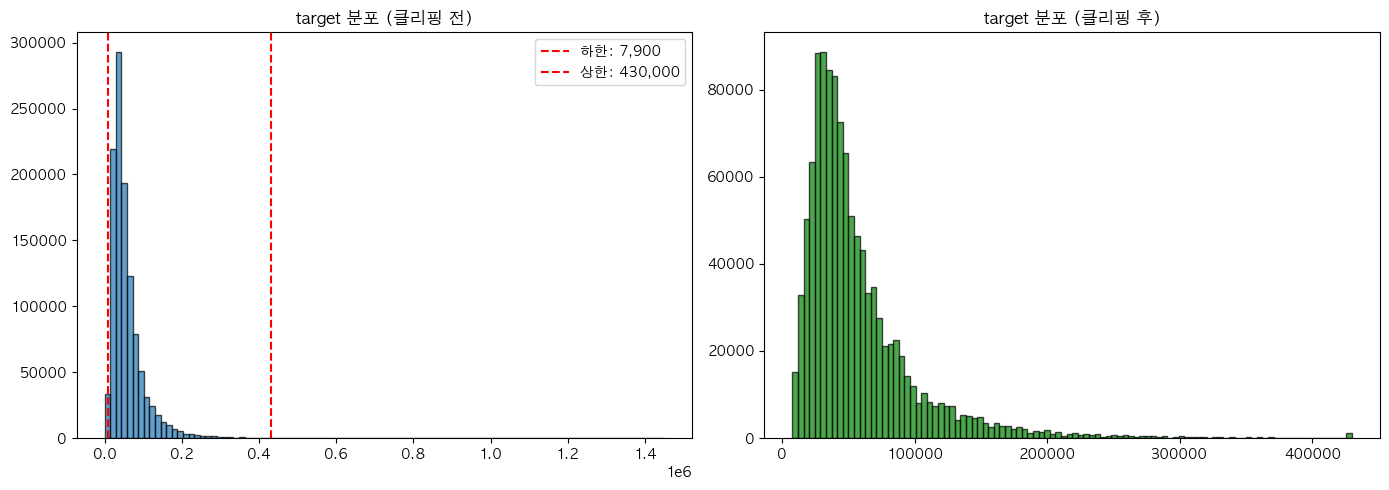

In [ ]:
# ── Target 이상치 클리핑 (퍼센타일 기반) ──
lower_pct = y_train.quantile(TARGET_LOWER_PERCENTILE)
upper_pct = y_train.quantile(TARGET_UPPER_PERCENTILE)

n_below = (y_train < lower_pct).sum()
n_above = (y_train > upper_pct).sum()

print(f"Target 클리핑 범위: [{lower_pct:,.0f}, {upper_pct:,.0f}] (만원)")
print(f"  하위 {TARGET_LOWER_PERCENTILE*100}% 이하: {n_below:,}건")
print(f"  상위 {TARGET_UPPER_PERCENTILE*100}% 이상: {n_above:,}건")
print(f"  총 클리핑: {n_below + n_above:,}건 ({(n_below + n_above) / len(y_train) * 100:.3f}%)")

y_train = y_train.clip(lower=lower_pct, upper=upper_pct)

# 클리핑 전후 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_df["target"], bins=100, alpha=0.7, edgecolor="black")
axes[0].set_title("target 분포 (클리핑 전)")
axes[0].axvline(lower_pct, color="red", linestyle="--", label=f"하한: {lower_pct:,.0f}")
axes[0].axvline(upper_pct, color="red", linestyle="--", label=f"상한: {upper_pct:,.0f}")
axes[0].legend()

axes[1].hist(y_train, bins=100, alpha=0.7, edgecolor="black", color="green")
axes[1].set_title("target 분포 (클리핑 후)")

plt.tight_layout()
plt.show()

---

## 11. Step 9 — Target 로그 변환

아파트 가격은 **우측으로 꼬리가 긴 분포(right-skewed)**를 보이므로 `log1p` 변환으로 정규분포에 가깝게 만듭니다.

| 변환 | 학습 시 | RMSE 계산 | 효과 |
|------|--------|-----------|------|
| 없음 | 원본 가격으로 학습 | 고가 아파트 오차가 지배적 | 저가 아파트 예측 부정확 |
| **log1p** | 로그 스케일로 학습 | 비율 기반 오차 학습 | 전 가격대에서 균형 잡힌 예측 |

> 예측 시에는 `expm1`으로 역변환하여 원래 가격 스케일로 복원합니다.

변환 전 - 범위: [7,900, 430,000]
변환 후 - 범위: [8.9747, 12.9715]
변환 전 왜도: 2.9075
변환 후 왜도: 0.2845

역변환 최대 오차: 0.0000000003 (0에 가까울수록 정확)


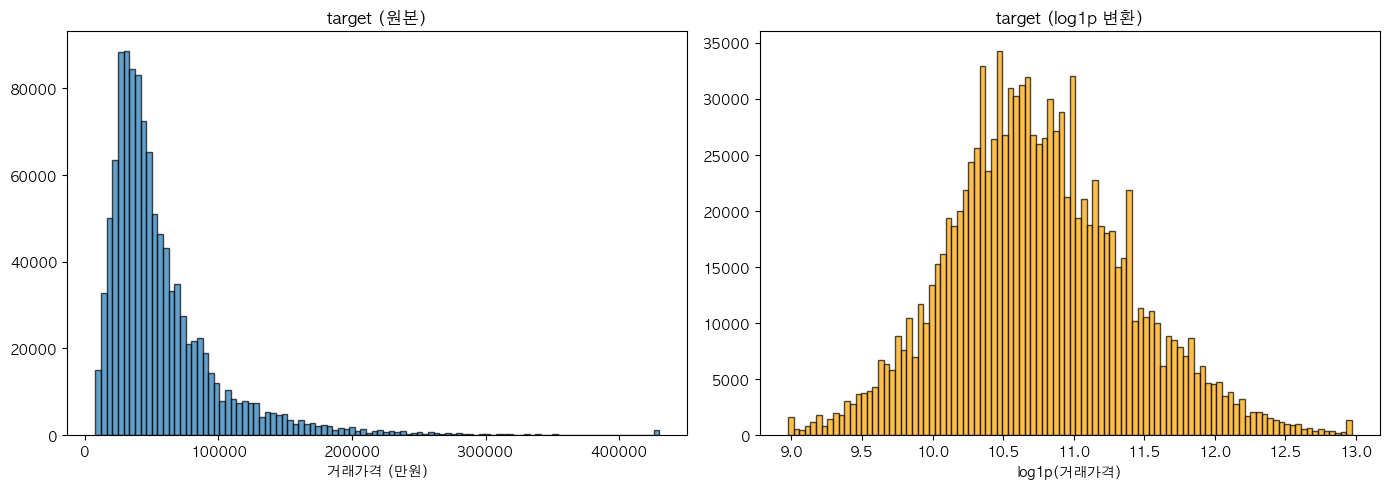

In [ ]:
def log_transform_target(y: pd.Series) -> pd.Series:
    """Target에 log1p 변환을 적용합니다."""
    return np.log1p(y)


def inverse_log_transform(y_log: np.ndarray) -> np.ndarray:
    """log1p 변환을 역변환합니다 (예측 시 사용)."""
    return np.expm1(y_log)


# ── 로그 변환 적용 ──
y_train_log = log_transform_target(y_train)

print(f"변환 전 - 범위: [{y_train.min():,.0f}, {y_train.max():,.0f}]")
print(f"변환 후 - 범위: [{y_train_log.min():.4f}, {y_train_log.max():.4f}]")
print(f"변환 전 왜도: {y_train.skew():.4f}")
print(f"변환 후 왜도: {y_train_log.skew():.4f}")

# 역변환 검증
y_restored = inverse_log_transform(y_train_log.values)
max_error = np.max(np.abs(y_train.values - y_restored))
print(f"\n역변환 최대 오차: {max_error:.10f} (0에 가까울수록 정확)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=100, alpha=0.7, edgecolor="black")
axes[0].set_title("target (원본)")
axes[0].set_xlabel("거래가격 (만원)")

axes[1].hist(y_train_log, bins=100, alpha=0.7, edgecolor="black", color="orange")
axes[1].set_title("target (log1p 변환)")
axes[1].set_xlabel("log1p(거래가격)")

plt.tight_layout()
plt.show()

---

## 12. 전처리 결과 검증 및 요약

In [ ]:
# ══════════════════════════════════════════════
# 전처리 결과 요약
# ══════════════════════════════════════════════

print("=" * 60)
print("전처리 완료 — 최종 결과 요약")
print("=" * 60)

print(f"\n[데이터 형상]")
print(f"  X_train:     {X_train.shape}")
print(f"  y_train_log: {y_train_log.shape}")
print(f"  X_test:      {X_test.shape}")

# 결측 확인
train_na = X_train.isnull().sum().sum()
test_na = X_test.isnull().sum().sum()
print(f"\n[잔여 결측]")
print(f"  X_train: {train_na:,}건")
print(f"  X_test:  {test_na:,}건")

# 수치형 / 범주형 비율
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols_final = [c for c in categorical_cols if c in X_train.columns]
print(f"\n[컬럼 구성]")
print(f"  수치형: {len(num_cols)}개")
print(f"  범주형: {len(cat_cols_final)}개")
print(f"  전체:   {len(X_train.columns)}개")

# train_stats 확인
print(f"\n[학습 기준 통계 (train_stats)]")
for key, val in train_stats.items():
    if isinstance(val, dict):
        print(f"  {key}: {len(val)}개 항목")
    else:
        print(f"  {key}: {type(val).__name__}")

전처리 완료 — 최종 결과 요약

[데이터 형상]
  X_train:     (1118822, 46)
  y_train_log: (1118822,)
  X_test:      (9272, 46)

[잔여 결측]
  X_train: 5,223,878건
  X_test:  39,426건

[컬럼 구성]
  수치형: 19개
  범주형: 18개
  전체:   46개

[학습 기준 통계 (train_stats)]
  coord_group_means: 2개 항목
  coord_global_means: 2개 항목
  numeric_medians: 11개 항목


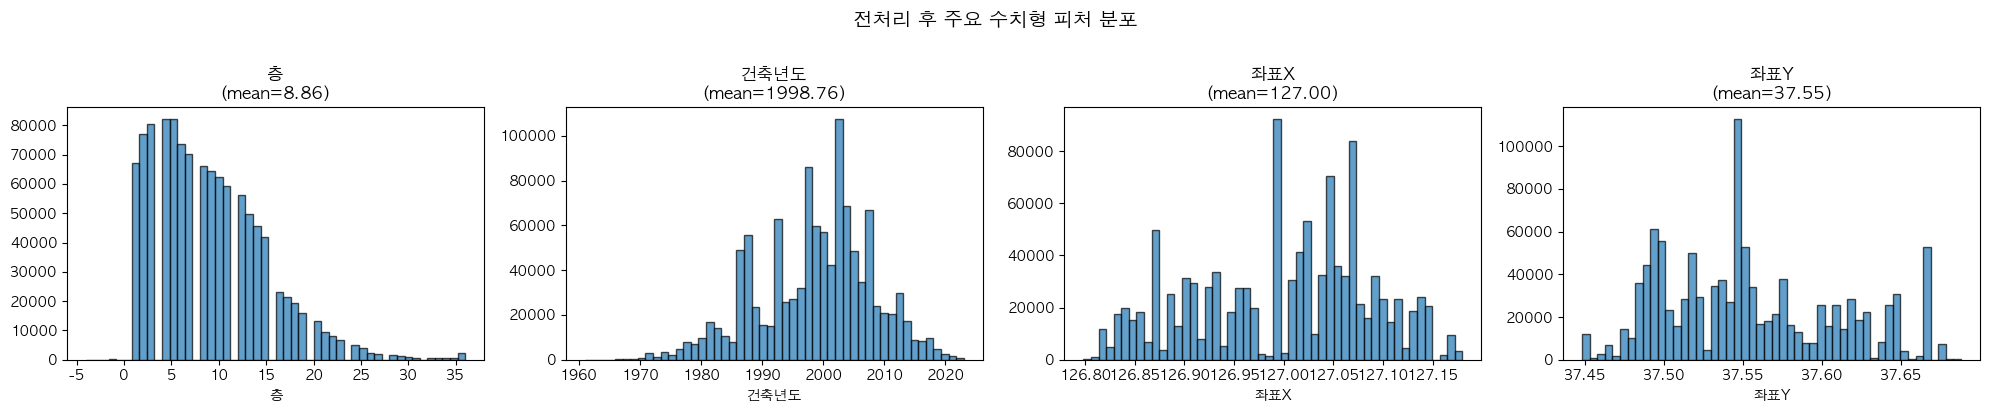

In [ ]:
# ── 전처리 후 수치형 피처 분포 확인 ──
key_numeric_cols = ["전용면적", "층", "건축년도", "좌표X", "좌표Y"]
available_cols = [c for c in key_numeric_cols if c in X_train.columns]

if available_cols:
    fig, axes = plt.subplots(1, len(available_cols), figsize=(5 * len(available_cols), 4))
    if len(available_cols) == 1:
        axes = [axes]

    for ax, col in zip(axes, available_cols):
        ax.hist(X_train[col].dropna(), bins=50, alpha=0.7, edgecolor="black")
        ax.set_title(f"{col}\n(mean={X_train[col].mean():.2f})")
        ax.set_xlabel(col)

    plt.suptitle("전처리 후 주요 수치형 피처 분포", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
# ── Train/Test 컬럼 일치 확인 ──
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

only_train = train_cols - test_cols
only_test = test_cols - train_cols
common = train_cols & test_cols

print(f"공통 컬럼: {len(common)}개")
if only_train:
    print(f"학습에만 있는 컬럼 ({len(only_train)}개): {sorted(only_train)}")
if only_test:
    print(f"테스트에만 있는 컬럼 ({len(only_test)}개): {sorted(only_test)}")

if not only_train and not only_test:
    print("학습/테스트 컬럼 완벽 일치!")

공통 컬럼: 46개
학습/테스트 컬럼 완벽 일치!


---

## 13. 통합 전처리 함수

위의 모든 단계를 하나의 함수로 통합합니다. 이후 파이프라인에서 바로 호출할 수 있습니다.

In [ ]:
def preprocess_train_data(
    train_df: pd.DataFrame,
    clip_target: bool = True,
) -> tuple:
    """학습 데이터 전처리 통합 함수

    Returns:
        (X_train, y_train_log, categorical_cols, train_stats)
    """
    train_stats = {}

    # Step 1: Target 분리
    y = train_df["target"].copy()
    X = train_df.drop(columns=["target"]).copy()

    # Step 2: 고결측 컬럼 제거
    X = remove_high_missing_columns(X)

    # Step 3: 컬럼명 정리
    X = sanitize_column_names(X)

    # Step 4: 범주형 식별
    cat_cols = identify_categorical_columns(X)

    # Step 5: 결측 지표 피처
    X["missing_count"] = X.isnull().sum(axis=1)

    # Step 6: 좌표 보간
    X, coord_group_means, coord_global_means = interpolate_coordinates(X)
    train_stats["coord_group_means"] = coord_group_means
    train_stats["coord_global_means"] = coord_global_means

    # Step 7: 결측값 대체
    X, numeric_medians = handle_missing_values(X, cat_cols)
    train_stats["numeric_medians"] = numeric_medians

    # Step 8: 이상치 클리핑
    X = clip_outliers(X, OUTLIER_CLIP_COLS)

    if clip_target:
        lower_pct = y.quantile(TARGET_LOWER_PERCENTILE)
        upper_pct = y.quantile(TARGET_UPPER_PERCENTILE)
        y = y.clip(lower=lower_pct, upper=upper_pct)

    # Step 9: Target 로그 변환
    y_log = log_transform_target(y)

    return X, y_log, cat_cols, train_stats


def preprocess_test_data(
    test_df: pd.DataFrame,
    categorical_cols: list,
    train_stats: dict = None,
) -> pd.DataFrame:
    """테스트 데이터 전처리 통합 함수

    학습 데이터에서 계산한 train_stats를 사용하여
    데이터 누수 없이 동일한 전처리를 적용합니다.
    """
    X = test_df.copy()

    # Step 2: 고결측 컬럼 제거
    X = remove_high_missing_columns(X)

    # Step 3: 컬럼명 정리
    X = sanitize_column_names(X)

    # Step 5: 결측 지표 피처
    X["missing_count"] = X.isnull().sum(axis=1)

    # Step 6: 좌표 보간 (학습 기준 통계)
    X, _, _ = interpolate_coordinates(X, stats=train_stats)

    # Step 7: 결측값 대체 (학습 기준 중앙값)
    numeric_medians = train_stats.get("numeric_medians", {}) if train_stats else {}
    X, _ = handle_missing_values(X, categorical_cols, numeric_medians=numeric_medians)

    return X


print("통합 전처리 함수 정의 완료")
print("  - preprocess_train_data(train_df) → (X, y_log, cat_cols, train_stats)")
print("  - preprocess_test_data(test_df, cat_cols, train_stats) → X_test")

통합 전처리 함수 정의 완료
  - preprocess_train_data(train_df) → (X, y_log, cat_cols, train_stats)
  - preprocess_test_data(test_df, cat_cols, train_stats) → X_test


---

## 14. 전처리 후 데이터 미리보기

In [ ]:
# ── 전처리 결과 미리보기 ──
print("X_train 상위 5행:")
X_train.head()

X_train 상위 5행:


,시군구,번지,본번,부번,아파트명,전용면적_㎡_,계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,k-단지분류_아파트_주상복합등등_,k-전화번호,k-팩스번호,k-세대타입_분양형태_,k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사_시공사_,k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황_60㎡이하_,k-전용면적별세대현황_60㎡~85㎡이하_,k-85㎡~135㎡이하,k-수정일자,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의_1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,missing_count
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,,-,-,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,768.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,직영,단일계약,직영,4858.0,683.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,,-,-,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,768.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,직영,단일계약,직영,4858.0,683.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,언주로 3,,-,-,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,768.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,직영,단일계약,직영,4858.0,683.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,,-,-,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,768.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,직영,단일계약,직영,4858.0,683.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,,-,-,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,768.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,직영,단일계약,직영,4858.0,683.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,0


In [ ]:
# ── 전처리된 데이터 dtypes 확인 ──
print("컬럼별 dtype:")
X_train.dtypes

컬럼별 dtype:


시군구                           str
번지                            str
본번                        float64
부번                        float64
아파트명                          str
전용면적_㎡_                   float64
계약년월                        int64
계약일                         int64
층                           int64
건축년도                        int64
도로명                           str
등기신청일자                        str
거래유형                          str
중개사소재지                        str
k-단지분류_아파트_주상복합등등_            str
k-전화번호                     object
k-팩스번호                     object
k-세대타입_분양형태_                  str
k-관리방식                        str
k-복도유형                        str
k-난방방식                        str
k-전체동수                     object
k-전체세대수                   float64
k-건설사_시공사_                    str
k-시행사                         str
k-사용검사일-사용승인일                 str
k-연면적                     float64
k-주거전용면적                  float64
k-관리비부과면적                 float64
k-전용면적별세대현황_60